In [89]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
import itertools

# 1. Load the MovieLens 1M dataset

def load_movielens_1m(path_to_ratings='C:/Users/immer/Downloads/ratings.dat'):
    df = pd.read_csv(
        path_to_ratings, 
        sep='::', 
        engine='python', 
        names=['user_id','movie_id','rating','timestamp']
    )
    return df

def preprocess_data(df, min_user_ratings=5):
    user_counts = df['user_id'].value_counts()
    valid_users = user_counts[user_counts >= min_user_ratings].index
    df_filtered = df[df['user_id'].isin(valid_users)]
    return df_filtered

if __name__ == "__main__":
    df = load_movielens_1m('C:/Users/immer/Downloads/ratings.dat')
    df = preprocess_data(df, min_user_ratings=5)
    
    print("Data shape after preprocessing:", df.shape)
    print(df.head())


Data shape after preprocessing: (1000209, 4)
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291


In [90]:
def create_user_item_matrix(df):
    user_item = df.pivot_table(
        index='user_id',
        columns='movie_id',
        values='rating'
    )
    return user_item

def compute_similarity(user_item, metric='cosine'):
    # Replace NaN with 0 for similarity computation or keep as NaN for advanced measures
    user_item_filled = user_item.fillna(0)
    
    if metric == 'cosine':
        sim_matrix = cosine_similarity(user_item_filled)
    elif metric == 'pearson':
        # Pairwise_distances with correlation computes 1 - Pearson's r
        dist_matrix = pairwise_distances(user_item_filled, metric='correlation')
        sim_matrix = 1 - dist_matrix
    else:
        raise ValueError("Unknown similarity metric: choose 'cosine' or 'pearson'")
    
    return sim_matrix

if __name__ == "__main__":
    user_item = create_user_item_matrix(df)
    sim_matrix = compute_similarity(user_item, metric='cosine')
    print("Similarity matrix shape:", sim_matrix.shape)


Similarity matrix shape: (6040, 6040)


In [91]:
'''''
def create_user_groups(sim_matrix, user_ids, group_size=5, n_groups=50, group_type='similar'):
    groups = []
    num_users = len(user_ids)
    
    for _ in range(n_groups):
        seed_index = np.random.randint(0, num_users)
        # Sort users by similarity to the seed
        user_sim = sim_matrix[seed_index]
        if group_type == 'similar':
            # top group_size-1 (excluding the seed itself)
            # argsort in descending order
            sorted_indices = np.argsort(-user_sim)
        else:
            # 'dissimilar' - sort in ascending order
            sorted_indices = np.argsort(user_sim)
        
        # The seed is sorted_indices[0] if 'similar', but we want unique user set
        chosen_indices = [seed_index]
        
        # Collect the top-4 or bottom-4 after the seed
        for idx in sorted_indices:
            if idx != seed_index and len(chosen_indices) < group_size:
                chosen_indices.append(idx)
        
        # Map indices back to user IDs
        group_user_ids = [user_ids[i] for i in chosen_indices]
        groups.append(group_user_ids)
    
    return groups

if __name__ == "__main__":
    user_ids = user_item.index.to_numpy()
    
    # Example: 50 "similar" groups of size 5
    similar_groups = create_user_groups(
        sim_matrix, user_ids, group_size=5, n_groups=50, group_type='similar'
    )
    print("Example of similar groups:", similar_groups)
    
    # Example: 50 "dissimilar" groups of size 5
    dissimilar_groups = create_user_groups(
        sim_matrix, user_ids, group_size=5, n_groups=50, group_type='dissimilar'
    )
    print("Example of dissimilar groups:", dissimilar_groups)

    '''''

'\'\'\ndef create_user_groups(sim_matrix, user_ids, group_size=5, n_groups=50, group_type=\'similar\'):\n    groups = []\n    num_users = len(user_ids)\n    \n    for _ in range(n_groups):\n        seed_index = np.random.randint(0, num_users)\n        # Sort users by similarity to the seed\n        user_sim = sim_matrix[seed_index]\n        if group_type == \'similar\':\n            # top group_size-1 (excluding the seed itself)\n            # argsort in descending order\n            sorted_indices = np.argsort(-user_sim)\n        else:\n            # \'dissimilar\' - sort in ascending order\n            sorted_indices = np.argsort(user_sim)\n        \n        # The seed is sorted_indices[0] if \'similar\', but we want unique user set\n        chosen_indices = [seed_index]\n        \n        # Collect the top-4 or bottom-4 after the seed\n        for idx in sorted_indices:\n            if idx != seed_index and len(chosen_indices) < group_size:\n                chosen_indices.append(idx

In [92]:
import numpy as np

def create_user_groups_filtered(
    sim_matrix,            # user-user similarity matrix
    user_ids,              # array of user IDs in the same order as sim_matrix rows/cols
    user_item,             # user-item matrix or DataFrame to count user ratings
    group_size=5,
    n_groups=50,
    group_type='similar',
    min_ratings=20,        # only pick seeds who have at least this many ratings
    min_similarity=0.3,    # require neighbors to have sim >= this
    max_attempts=10000,
    user_id_to_index=None
):


    # If not provided, build a quick map from user IDs to sim_matrix index
    if user_id_to_index is None:
        user_id_to_index = {uid: i for i, uid in enumerate(user_ids)}
    
    # Step 1: Filter seeds to only 'active' users
    # We'll define 'active' as having >= min_ratings rated items in user_item
    active_user_ids = []
    for uid in user_ids:
        # Count how many rated items (non-NaN or non-zero) the user has
        # If user_item is a DataFrame: user_item.loc[uid].count() counts non-NaN
        # If user_item is just an array, do something else
        num_rated = user_item.loc[uid].count()
        if num_rated >= min_ratings:
            active_user_ids.append(uid)
    
    groups = []
    attempts = 0
    num_users = len(user_ids)
    
    while len(groups) < n_groups and attempts < max_attempts:
        attempts += 1
        
        # Randomly pick a seed from the active users
        seed_uid = np.random.choice(active_user_ids)
        seed_index = user_id_to_index[seed_uid]
        
        user_sim = sim_matrix[seed_index]
        
        if group_type == 'similar':
            # We want neighbors with sim >= min_similarity
            valid_indices = [i for i in range(num_users) 
                             if i != seed_index and user_sim[i] >= min_similarity]
            # Sort them in descending order of similarity
            valid_indices.sort(key=lambda i: user_sim[i], reverse=True)
            
        else:  # group_type == 'dissimilar'
            # We'll define "dissimilar" as neighbors with sim <= some max_similarity
            # e.g., use the 'min_similarity' param as a max threshold
            max_sim_threshold = 0.1  # or choose your own threshold
            valid_indices = [i for i in range(num_users) 
                             if i != seed_index and user_sim[i] <= max_sim_threshold]
            # Sort them in ascending order of similarity
            valid_indices.sort(key=lambda i: user_sim[i], reverse=False)
        
        # Now pick top (group_size - 1) from valid_indices
        if len(valid_indices) >= (group_size - 1):
            chosen_indices = [seed_index] + valid_indices[:(group_size - 1)]
            group_user_ids = [user_ids[i] for i in chosen_indices]
            groups.append(group_user_ids)
        # else we skip this seed and try another
    
    return groups


In [93]:
user_ids = user_item.index.to_numpy()
user_id_to_index = {uid: i for i, uid in enumerate(user_ids)}

similar_groups = create_user_groups_filtered(
    sim_matrix=sim_matrix,
    user_ids=user_ids,
    user_item=user_item,
    group_size=5,
    n_groups=50,
    group_type='similar',
    min_ratings=20,
    min_similarity=0.4,   # try 0.4 or 0.5
    max_attempts=10000,
    user_id_to_index=user_id_to_index
)
print("Number of 'similar' groups formed:", len(similar_groups))
for i, g in enumerate(similar_groups):
    print(f"Group {i} => {g}")

dissimilar_groups = create_user_groups_filtered(
    sim_matrix=sim_matrix,
    user_ids=user_ids,
    user_item=user_item,
    group_size=5,
    n_groups=50,
    group_type='dissimilar',
    min_ratings=20,
    min_similarity=0.3,
    max_attempts=10000,
    user_id_to_index=user_id_to_index
)
print("Number of 'dissimilar' groups formed:", len(dissimilar_groups))
for i, g in enumerate(dissimilar_groups):
    print(f"Group {i} => {g}")


Number of 'similar' groups formed: 50
Group 0 => [2232, 3620, 774, 692, 1860]
Group 1 => [1772, 2381, 5867, 3918, 675]
Group 2 => [6026, 5778, 2126, 1522, 2284]
Group 3 => [1632, 1899, 2544, 4344, 5100]
Group 4 => [1850, 1938, 541, 563, 3715]
Group 5 => [5738, 4279, 4238, 5627, 3265]
Group 6 => [1635, 4386, 5367, 4508, 1447]
Group 7 => [5185, 2497, 4422, 3138, 513]
Group 8 => [3921, 182, 1773, 56, 3450]
Group 9 => [4704, 4048, 2529, 3401, 48]
Group 10 => [3640, 3574, 3656, 3670, 3734]
Group 11 => [1685, 1285, 1899, 1019, 1383]
Group 12 => [5186, 5997, 5882, 5778, 3731]
Group 13 => [5077, 1077, 1015, 1019, 1285]
Group 14 => [4732, 4884, 4510, 4448, 4508]
Group 15 => [5874, 1340, 58, 2303, 3693]
Group 16 => [2262, 2403, 5982, 3556, 5931]
Group 17 => [1097, 403, 2771, 781, 4217]
Group 18 => [513, 5185, 4091, 4024, 3727]
Group 19 => [262, 6030, 3678, 5307, 4333]
Group 20 => [4869, 4867, 4480, 1285, 5090]
Group 21 => [3518, 3519, 1980, 3462, 752]
Group 22 => [1340, 4386, 1579, 5367, 1264]
G

In [94]:
def compute_group_similarity_stats(group_user_ids, sim_matrix, user_id_to_index):
    import numpy as np
    
    # Convert user IDs to row indices
    indices = [user_id_to_index[uid] for uid in group_user_ids]
    
    # Extract sub-matrix
    submatrix = sim_matrix[np.ix_(indices, indices)]
    
    # Exclude diagonal (self-similarities)
    n = len(indices)
    if n > 1:
        tri_vals = []
        for i in range(n):
            for j in range(i+1, n):
                tri_vals.append(submatrix[i,j])
        tri_vals = np.array(tri_vals)
        
        avg_sim   = tri_vals.mean()
        min_sim   = tri_vals.min()
        max_sim   = tri_vals.max()
        avg_dissim = (1 - tri_vals).mean()  # simplistic approach
        
        return {
            'average_similarity': float(avg_sim),
            'min_similarity': float(min_sim),
            'max_similarity': float(max_sim),
            'average_dissimilarity': float(avg_dissim)
        }
    else:
        # If there's only 1 user, trivial stats
        return {
            'average_similarity': 1.0,
            'min_similarity': 1.0,
            'max_similarity': 1.0,
            'average_dissimilarity': 0.0
        }


In [95]:
def print_filtered_group_similarities(groups, sim_matrix, user_id_to_index, group_type="similar"):
    print(f"\n=== {group_type.capitalize()} Groups ===")
    for idx, group_user_ids in enumerate(groups):
        stats = compute_group_similarity_stats(group_user_ids, sim_matrix, user_id_to_index)
        print(f"Group #{idx} ({group_type.capitalize()}) - Users: {group_user_ids}")
        print(f"  Avg similarity     : {stats['average_similarity']:.4f}")
        print(f"  Min similarity     : {stats['min_similarity']:.4f}")
        print(f"  Max similarity     : {stats['max_similarity']:.4f}")
        print(f"  Avg dissimilarity  : {stats['average_dissimilarity']:.4f}")
        print("-----")


In [96]:
if __name__ == "__main__":
    user_ids = user_item.index.to_numpy()
    
    # Create user->index map
    user_id_to_index = {uid: i for i, uid in enumerate(user_ids)}

    # 2) Create 50 'truly similar' groups
    similar_groups_filtered = create_user_groups_filtered(
        sim_matrix=sim_matrix,
        user_ids=user_ids,
        user_item=user_item,
        group_size=5,
        n_groups=50,
        group_type='similar',
        min_ratings=20,
        min_similarity=0.4,   # or 0.5, etc.
        max_attempts=10000,
        user_id_to_index=user_id_to_index
    )

    # 3) Create 50 'truly dissimilar' groups
    dissimilar_groups_filtered = create_user_groups_filtered(
        sim_matrix=sim_matrix,
        user_ids=user_ids,
        user_item=user_item,
        group_size=5,
        n_groups=50,
        group_type='dissimilar',
        min_ratings=20,       # or possibly 10
        min_similarity=0.3,   # internally we interpret it as max_sim=0.1, etc.
        max_attempts=10000,
        user_id_to_index=user_id_to_index
    )
    
    print_filtered_group_similarities(similar_groups_filtered, sim_matrix, user_id_to_index, group_type="similar")
    print_filtered_group_similarities(dissimilar_groups_filtered, sim_matrix, user_id_to_index, group_type="dissimilar")



=== Similar Groups ===
Group #0 (Similar) - Users: [1025, 815, 370, 643, 3728]
  Avg similarity     : 0.4774
  Min similarity     : 0.3915
  Max similarity     : 0.5603
  Avg dissimilarity  : 0.5226
-----
Group #1 (Similar) - Users: [127, 774, 876, 2022, 2025]
  Avg similarity     : 0.4345
  Min similarity     : 0.3535
  Max similarity     : 0.5232
  Avg dissimilarity  : 0.5655
-----
Group #2 (Similar) - Users: [679, 2591, 236, 4595, 3270]
  Avg similarity     : 0.3841
  Min similarity     : 0.3227
  Max similarity     : 0.4311
  Avg dissimilarity  : 0.6159
-----
Group #3 (Similar) - Users: [5227, 4377, 2186, 2886, 2445]
  Avg similarity     : 0.4775
  Min similarity     : 0.3500
  Max similarity     : 0.6123
  Avg dissimilarity  : 0.5225
-----
Group #4 (Similar) - Users: [2599, 563, 42, 1695, 3665]
  Avg similarity     : 0.4970
  Min similarity     : 0.4327
  Max similarity     : 0.5752
  Avg dissimilarity  : 0.5030
-----
Group #5 (Similar) - Users: [4647, 1285, 1015, 4277, 1150]
  A

In [97]:
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import train_test_split

def train_svd_model(df):
    # Surprise expects a DataFrame with columns: user, item, rating
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(df[['user_id','movie_id','rating']], reader)
    
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    
    # Initialize SVD
    svd = SVD(n_factors=50, reg_all=0.02, random_state=42)
    svd.fit(trainset)
    
    # Evaluate
    predictions = svd.test(testset)
    rmse = accuracy.rmse(predictions, verbose=True)
    
    print(f"SVD Model trained. Test RMSE: {rmse:.4f}")
    return svd

def predict_rating(svd, userId, itemId):
    pred = svd.predict(userId, itemId)
    return pred.est

def bulk_predict_ratings(svd, users, items):
    preds = []
    for u in users:
        for i in items:
            est = svd.predict(u, i).est
            preds.append((u, i, est))
    df_preds = pd.DataFrame(preds, columns=['user_id','movie_id','est_rating'])
    return df_preds

if __name__ == "__main__":
    svd = train_svd_model(df)
    
    # Example single rating prediction
    example_user, example_item = df.iloc[0]['user_id'], df.iloc[0]['movie_id']
    print("Example prediction:", predict_rating(svd, example_user, example_item))


RMSE: 0.8706
SVD Model trained. Test RMSE: 0.8706
Example prediction: 4.7681933650458745


In [98]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

def compute_item_popularity(df):
    total_users = df['user_id'].nunique()
    item_counts = df.groupby('movie_id')['user_id'].nunique()
    popularity = (item_counts / total_users).to_dict()
    return popularity

def compute_group_item_score(
    df, svd, group_user_ids, all_movie_ids, popularity_dict, 
    w_intensity=0.4, w_pop=0.3, w_relevance=0.3
):
    # 1) Compute item intensity for the group
    group_df = df[df['user_id'].isin(group_user_ids)]
    
    # Actual rating means for items rated by at least one group member
    intensity_series = group_df.groupby('movie_id')['rating'].mean()
    
    # Relevance: use SVD predicted rating for each user in the group, then average
    preds = []
    for m in all_movie_ids:
        group_est = []
        for u in group_user_ids:
            est = svd.predict(u, m).est
            group_est.append(est)
        avg_est = np.mean(group_est)
        preds.append((m, avg_est))
    relevance_df = pd.DataFrame(preds, columns=['movie_id','relevance'])
    
    # Build a final DataFrame
    score_df = pd.DataFrame({'movie_id': all_movie_ids})
    
    # Merge intensity (some items may be missing if no actual rating from group)
    score_df = score_df.merge(
        intensity_series.rename('intensity'), on='movie_id', how='left'
    )
    
    # If intensity is missing (the group never rated it), fallback on 0
    score_df['intensity'] = score_df['intensity'].fillna(0.0)
    
    # Merge relevance
    score_df = score_df.merge(relevance_df, on='movie_id', how='left')
    
    # Merge popularity
    score_df['pop'] = score_df['movie_id'].map(popularity_dict).fillna(0.0)
    
    # Normalize each component [0..1]
    scaler = MinMaxScaler()
    score_df[['intensity', 'pop', 'relevance']] = scaler.fit_transform(
        score_df[['intensity', 'pop', 'relevance']]
    )
    
    # Weighted sum
    score_df['item_score'] = (
        w_intensity * score_df['intensity'] +
        w_pop * score_df['pop'] +
        w_relevance * score_df['relevance']
    )
    
    return score_df

if __name__ == "__main__":
    # Compute popularity dictionary
    popularity_dict = compute_item_popularity(df)
    
    # Get all unique movie IDs
    all_movie_ids = df['movie_id'].unique()
    
    # Results storage
    group_scores = {}
    
    # Loop through similar groups
    for i, group_user_ids in enumerate(similar_groups):
        score_df = compute_group_item_score(
            df, svd, group_user_ids, all_movie_ids, popularity_dict
        )
        group_scores[f"similar_group_{i+1}"] = score_df
    
    # Loop through dissimilar groups
    for i, group_user_ids in enumerate(dissimilar_groups):
        score_df = compute_group_item_score(
            df, svd, group_user_ids, all_movie_ids, popularity_dict
        )
        group_scores[f"dissimilar_group_{i+1}"] = score_df
    
    # Example: Access results for a specific group
    print(group_scores)


{'similar_group_1':       movie_id  intensity  relevance       pop  item_score
0         1193   0.933333   0.912634  0.503064    0.798043
1          661   0.800000   0.664532  0.152903    0.565231
2          914   1.000000   0.749114  0.185293    0.680322
3         3408   0.700000   0.680290  0.383426    0.599115
4         2355   0.700000   0.741579  0.496644    0.651467
...        ...        ...        ...       ...         ...
3701      2198   0.000000   0.639525  0.000292    0.191945
3702      2703   0.000000   0.601178  0.000000    0.180353
3703      2845   0.000000   0.524418  0.000000    0.157325
3704      3607   0.000000   0.642262  0.000000    0.192679
3705      2909   0.000000   0.606052  0.000000    0.181816

[3706 rows x 5 columns], 'similar_group_2':       movie_id  intensity  relevance       pop  item_score
0         1193       1.00   0.965266  0.503064    0.840499
1          661       0.00   0.655498  0.152903    0.242521
2          914       0.00   0.823121  0.185293    

In [99]:
def get_top_n_recommendations(score_df, N=10):
    top_n = score_df.sort_values('item_score', ascending=False).head(N)
    return top_n

if __name__ == "__main__":
    top_10 = get_top_n_recommendations(score_df, N=10)
    print("Top-10 items for this group:\n", top_10)


Top-10 items for this group:
      movie_id  intensity  relevance       pop  item_score
44        260        1.0   0.946683  0.872483    0.945750
124      1196        1.0   0.849236  0.872191    0.916428
23        527        1.0   0.986075  0.672016    0.897427
38       2762        1.0   0.939923  0.717245    0.897150
127      1198        1.0   0.922510  0.733294    0.896741
167       318        1.0   0.990474  0.649548    0.892007
97        589        1.0   0.837294  0.772687    0.882994
5        1197        1.0   0.915838  0.676102    0.877582
134      2396        1.0   0.871859  0.690983    0.868853
22       1270        1.0   0.806495  0.753429    0.867977


In [100]:
from sklearn.cluster import KMeans
import numpy as np

def cluster_items_refined(
    score_df,
    feature_cols = ['intensity','pop','relevance'],
    init_n_clusters=30,
    max_cluster_size=50,
    min_cluster_size=5,
    random_state=42
):
    
    X = score_df[feature_cols].values
    
    # 1) Initial K-Means
    kmeans = KMeans(n_clusters=init_n_clusters, random_state=random_state)
    labels = kmeans.fit_predict(X)
    score_df['cluster_label'] = labels
    
    # Build dictionary {label: DataFrame of items}
    clusters_dict = {}
    for lbl in np.unique(labels):
        cluster_df = score_df[score_df['cluster_label'] == lbl]
        clusters_dict[lbl] = cluster_df
    
    # 2) Split clusters larger than max_cluster_size
    #    We'll store newly created clusters in an incremental ID counter
    refined_clusters = {}
    cluster_id_counter = 0
    
    for lbl, cdf in clusters_dict.items():
        if len(cdf) <= max_cluster_size:
            # no split needed
            refined_clusters[cluster_id_counter] = cdf
            cluster_id_counter += 1
        else:
            # Perform local K-Means on this cluster to break it down
            n_sub_clusters = int(np.ceil(len(cdf) / max_cluster_size))
            if n_sub_clusters == 1:
                # edge case: if it's just slightly over max_cluster_size,
                # keep as is (or you can forcibly split)
                refined_clusters[cluster_id_counter] = cdf
                cluster_id_counter += 1
            else:
                sub_kmeans = KMeans(n_clusters=n_sub_clusters, random_state=random_state)
                subX = cdf[feature_cols].values
                sub_labels = sub_kmeans.fit_predict(subX)
                
                for sub_lbl in np.unique(sub_labels):
                    sub_cluster_df = cdf[sub_labels == sub_lbl]
                    refined_clusters[cluster_id_counter] = sub_cluster_df
                    cluster_id_counter += 1
    
    # 3) Merge clusters smaller than min_cluster_size
    #    We'll do an iterative pass, merging small clusters with their "closest" neighbor
    #    (closest in centroid space) if it won't exceed max_cluster_size.
    
    def compute_centroid(df_cluster):
        # mean of feature columns
        return df_cluster[feature_cols].mean().values
    
    merged = True
    while merged:
        merged = False  # track if we performed any merge in this iteration
        
        all_ids = list(refined_clusters.keys())
        all_ids.sort()
        
        # Identify clusters below min_cluster_size
        small_clusters = [cid for cid in all_ids if len(refined_clusters[cid]) < min_cluster_size]
        
        for cid in small_clusters:
            if cid not in refined_clusters:
                continue  # might have been merged already
            
            cdf = refined_clusters[cid]
            centroid_small = compute_centroid(cdf)
            
            # Find the nearest cluster that can accept these items
            best_neighbor = None
            best_dist = float('inf')
            
            for neigh_id in all_ids:
                if neigh_id == cid or neigh_id not in refined_clusters:
                    continue
                neighbor_cdf = refined_clusters[neigh_id]
                if (len(neighbor_cdf) + len(cdf)) <= max_cluster_size:
                    centroid_neighbor = compute_centroid(neighbor_cdf)
                    dist = np.linalg.norm(centroid_small - centroid_neighbor)
                    if dist < best_dist:
                        best_dist = dist
                        best_neighbor = neigh_id
            
            if best_neighbor is not None:
                # Merge cid into best_neighbor
                refined_clusters[best_neighbor] = pd.concat([refined_clusters[best_neighbor], cdf])
                # Remove the small cluster
                del refined_clusters[cid]
                merged = True
                break  # break from loop, re-check from scratch (safer approach)
    
    # Re-label final clusters from 0..N-1
    final_clusters = {}
    new_id = 0
    for cid in sorted(refined_clusters.keys()):
        final_clusters[new_id] = refined_clusters[cid]
        new_id += 1
    
    return final_clusters


In [101]:
if __name__ == "__main__":
    # Compute item popularity once for the entire dataset
    popularity_dict = compute_item_popularity(df)
    all_movie_ids = df['movie_id'].unique()

    # Results storage
    refined_clusters_all_groups = {}

    # Process similar groups
    for group_idx, group_user_ids in enumerate(similar_groups):
        print(f"\nProcessing Similar Group {group_idx + 1}...")
        
        # Compute item scores for the group
        score_df = compute_group_item_score(
            df, svd, group_user_ids, all_movie_ids, popularity_dict
        )
        
        # Cluster items for this group
        refined_clusters = cluster_items_refined(
            score_df,
            feature_cols=['intensity', 'pop', 'relevance'],
            init_n_clusters=30,
            max_cluster_size=50,
            min_cluster_size=5
        )
        
        # Save the refined clusters for this group
        refined_clusters_all_groups[f"similar_group_{group_idx + 1}"] = refined_clusters
        
        # Print results for this group
        print(f"Number of final clusters for Similar Group {group_idx + 1}: {len(refined_clusters)}")
        for cid, cdf in refined_clusters.items():
            print(f"  Cluster {cid} size: {len(cdf)}")
            print(f"    Items: {cdf['movie_id'].tolist()[:10]}...")  # Display first 10 items

    # Process dissimilar groups
    for group_idx, group_user_ids in enumerate(dissimilar_groups):
        print(f"\nProcessing Dissimilar Group {group_idx + 1}...")
        
        # Compute item scores for the group
        score_df = compute_group_item_score(
            df, svd, group_user_ids, all_movie_ids, popularity_dict
        )
        
        # Cluster items for this group
        refined_clusters = cluster_items_refined(
            score_df,
            feature_cols=['intensity', 'pop', 'relevance'],
            init_n_clusters=30,
            max_cluster_size=50,
            min_cluster_size=5
        )
        
        # Save the refined clusters for this group
        refined_clusters_all_groups[f"dissimilar_group_{group_idx + 1}"] = refined_clusters
        
        # Print results for this group
        print(f"Number of final clusters for Dissimilar Group {group_idx + 1}: {len(refined_clusters)}")
        for cid, cdf in refined_clusters.items():
            print(f"  Cluster {cid} size: {len(cdf)}")
            print(f"    Items: {cdf['movie_id'].tolist()}...")  # Display first 10 items



Processing Similar Group 1...
Number of final clusters for Similar Group 1: 88
  Cluster 0 size: 105
    Items: [1331, 3375, 2573, 2800, 3474, 2419, 957, 753, 453, 3049]...
  Cluster 1 size: 34
    Items: [1884, 1688, 1027, 2136, 3099, 2033, 2111, 216, 2567, 2346]...
  Cluster 2 size: 51
    Items: [3514, 3399, 2638, 187, 278, 467, 565, 2417, 1666, 3605]...
  Cluster 3 size: 98
    Items: [1529, 1880, 3349, 3935, 287, 1861, 184, 268, 664, 2913]...
  Cluster 4 size: 34
    Items: [1836, 1442, 3619, 2506, 2325, 1804, 2661, 1390, 2418, 3846]...
  Cluster 5 size: 42
    Items: [1794, 3425, 1621, 465, 1654, 2633, 2836, 2782, 1425, 3506]...
  Cluster 6 size: 27
    Items: [2337, 282, 1015, 277, 2453, 2043, 1753, 1498, 3036, 2553]...
  Cluster 7 size: 25
    Items: [2159, 383, 1701, 351, 3194, 986, 481, 2106, 3145, 1033]...
  Cluster 8 size: 71
    Items: [1715, 2047, 2507, 2663, 496, 2103, 1463, 1398, 2415, 2426]...
  Cluster 9 size: 23
    Items: [2687, 2294, 3893, 2333, 3020, 1120, 3259, 

In [102]:
def is_item_in_top_n(df, svd, group_user_ids, all_movie_ids, popularity_dict, target_item, N=10, removed_item_ids=None):
    # We can either remove those items from the dataset or set their intensities to 0
    # For clarity, let's remove them entirely from the scoring
    if removed_item_ids is None:
        removed_item_ids = set()
    
    valid_movie_ids = [m for m in all_movie_ids if m not in removed_item_ids]
    
    # Recompute scores for the subset
    score_df = compute_group_item_score(
        df, svd, group_user_ids, valid_movie_ids, popularity_dict
    )
    top_n_df = get_top_n_recommendations(score_df, N=N)
    
    return (target_item in top_n_df['movie_id'].values)

def identify_influential_clusters(
    df, svd, group_user_ids, all_movie_ids, popularity_dict, 
    clusters_dict, target_item, N=10
):
    influential_clusters = []
    for cid, cluster_df in clusters_dict.items():
        cluster_item_ids = cluster_df['movie_id'].unique().tolist()
        
        # Check presence of target_item after removing cluster_item_ids
        still_in = is_item_in_top_n(
            df, svd, group_user_ids, all_movie_ids, popularity_dict, 
            target_item, N=N, removed_item_ids=cluster_item_ids
        )
        if not still_in:
            # Means removal of this cluster caused target item to drop out
            influential_clusters.append(cid)
    
    return influential_clusters



In [103]:
if __name__ == "__main__":
    # Compute item popularity once for the entire dataset
    popularity_dict = compute_item_popularity(df)
    all_movie_ids = df['movie_id'].unique()

    # Results storage
    all_influential_clusters = {}

    # Function to get top-scored item in a group
    def get_top_scored_item(score_df):
        return score_df.sort_values(by='item_score', ascending=False).iloc[0]['movie_id']

    # Process similar groups
    for group_idx, group_user_ids in enumerate(similar_groups):
        print(f"\nProcessing Similar Group {group_idx + 1}...")

        # Compute item scores for the group
        score_df = compute_group_item_score(
            df, svd, group_user_ids, all_movie_ids, popularity_dict
        )

        # Dynamically determine the target item
        target_item = get_top_scored_item(score_df)
        print(f"Target item for Similar Group {group_idx + 1}: {target_item}")

        # Refine clusters for the group
        refined_clusters = cluster_items_refined(
            score_df,
            feature_cols=['intensity', 'pop', 'relevance'],
            init_n_clusters=30,
            max_cluster_size=50,
            min_cluster_size=5,
            random_state=42
        )

        # Identify influential clusters
        inf_clusters = identify_influential_clusters(
            df=df,
            svd=svd,
            group_user_ids=group_user_ids,
            all_movie_ids=all_movie_ids,
            popularity_dict=popularity_dict,
            clusters_dict=refined_clusters,
            target_item=target_item,
            N=10
        )

        # Save results for this group
        all_influential_clusters[f"similar_group_{group_idx + 1}"] = inf_clusters

        # Print results for this group
        print(f"Influential clusters for Similar Group {group_idx + 1}: {inf_clusters}")
        for cid in inf_clusters:
            inf_cluster_df = refined_clusters[cid]
            cluster_size = len(inf_cluster_df)
            items_in_cluster = inf_cluster_df['movie_id'].tolist()
            print(f"  Influential cluster ID: {cid}")
            print(f"    Size: {cluster_size}")
            print(f"    Items: {items_in_cluster[:10]}...")  # Show first 10 items for brevity

    # Process dissimilar groups
    for group_idx, group_user_ids in enumerate(dissimilar_groups):
        print(f"\nProcessing Dissimilar Group {group_idx + 1}...")

        # Compute item scores for the group
        score_df = compute_group_item_score(
            df, svd, group_user_ids, all_movie_ids, popularity_dict
        )

        # Dynamically determine the target item
        target_item = get_top_scored_item(score_df)
        print(f"Target item for Dissimilar Group {group_idx + 1}: {target_item}")

        # Refine clusters for the group
        refined_clusters = cluster_items_refined(
            score_df,
            feature_cols=['intensity', 'pop', 'relevance'],
            init_n_clusters=30,
            max_cluster_size=50,
            min_cluster_size=5,
            random_state=42
        )

        # Identify influential clusters
        inf_clusters = identify_influential_clusters(
            df=df,
            svd=svd,
            group_user_ids=group_user_ids,
            all_movie_ids=all_movie_ids,
            popularity_dict=popularity_dict,
            clusters_dict=refined_clusters,
            target_item=target_item,
            N=10
        )

        # Save results for this group
        all_influential_clusters[f"dissimilar_group_{group_idx + 1}"] = inf_clusters

        # Print results for this group
        print(f"Influential clusters for Dissimilar Group {group_idx + 1}: {inf_clusters}")
        for cid in inf_clusters:
            inf_cluster_df = refined_clusters[cid]
            cluster_size = len(inf_cluster_df)
            items_in_cluster = inf_cluster_df['movie_id'].tolist()
            print(f"  Influential cluster ID: {cid}")
            print(f"    Size: {cluster_size}")
            print(f"    Items: {items_in_cluster[:10]}...")  # Show first 10 items for brevity



Processing Similar Group 1...
Target item for Similar Group 1: 2858.0
Influential clusters for Similar Group 1: [45]
  Influential cluster ID: 45
    Size: 17
    Items: [1197, 527, 2762, 260, 2028, 608, 1210, 110, 2858, 1196]...

Processing Similar Group 2...
Target item for Similar Group 2: 2858.0
Influential clusters for Similar Group 2: [13]
  Influential cluster ID: 13
    Size: 7
    Items: [1270, 527, 1097, 1210, 2858, 2997, 2716]...

Processing Similar Group 3...
Target item for Similar Group 3: 260.0
Influential clusters for Similar Group 3: [83]
  Influential cluster ID: 83
    Size: 11
    Items: [527, 1097, 260, 589, 1196, 1198, 593, 2571, 318, 1240]...

Processing Similar Group 4...
Target item for Similar Group 4: 260.0
Influential clusters for Similar Group 4: [58]
  Influential cluster ID: 58
    Size: 32
    Items: [1197, 1270, 527, 1097, 2762, 1, 260, 2028, 608, 1210]...

Processing Similar Group 5...
Target item for Similar Group 5: 260.0
Influential clusters for Si

KeyboardInterrupt: 

In [69]:
def find_minimal_explanation_subsets(
    df,
    svd,
    group_user_ids,
    all_movie_ids,
    popularity_dict,
    cluster_item_ids,
    target_item,
    N=10
):
    
    # 1) Check if removing the entire cluster indeed excludes the target:
    if not is_item_in_top_n(
        df, svd, group_user_ids, all_movie_ids, popularity_dict,
        target_item, N=N, removed_item_ids=cluster_item_ids
    ):
        # We proceed to find smaller combos
        cluster_item_ids = list(cluster_item_ids)
        results = []
        best_size = len(cluster_item_ids) + 1

        def backtrack(start, current_subset):
            nonlocal best_size

            # If removing current_subset excludes the target, record or keep searching
            if not is_item_in_top_n(
                df, svd, group_user_ids, all_movie_ids, popularity_dict,
                target_item, N=N, removed_item_ids=current_subset
            ):
                # We found a subset that excludes target
                if len(current_subset) < best_size:
                    best_size = len(current_subset)
                    results.clear()
                    results.append(list(current_subset))
                elif len(current_subset) == best_size:
                    results.append(list(current_subset))
                return

            # Otherwise, continue searching if we haven't exceeded the best size
            for i in range(start, len(cluster_item_ids)):
                # Pruning: if adding another item would exceed best_size, skip
                if len(current_subset) + 1 > best_size:
                    break

                current_subset.append(cluster_item_ids[i])
                backtrack(i+1, current_subset)
                current_subset.pop()

        backtrack(0, [])
        return results
    else:
        # If removing the entire cluster does NOT exclude the target item,
        # there's no smaller subset that can exclude it, so return empty list
        return []


In [70]:
def refine_influential_clusters(
    df,
    svd,
    group_user_ids,
    all_movie_ids,
    popularity_dict,
    influential_clusters,
    target_item,
    N=10
):
    refined_results = {}
    
    for cid, cluster_df in influential_clusters.items():
        print(f"\nRefining Influential Cluster {cid}...")
        cluster_item_ids = cluster_df['movie_id'].unique().tolist()
        
        # We attempt to find minimal subsets
        min_subsets = find_minimal_explanation_subsets(
            df=df,
            svd=svd,
            group_user_ids=group_user_ids,
            all_movie_ids=all_movie_ids,
            popularity_dict=popularity_dict,
            cluster_item_ids=cluster_item_ids,
            target_item=target_item,
            N=N
        )
        
        if min_subsets:
            print(f"  Found {len(min_subsets)} minimal subset(s) in cluster {cid}")
            for s_idx, subset in enumerate(min_subsets):
                print(f"    Subset #{s_idx+1} of size {len(subset)} -> {subset}")
        else:
            print(f"  No smaller subset in cluster {cid} alone excludes the target item.")
        
        refined_results[cid] = min_subsets
    
    return refined_results


In [71]:
def generate_recommendations(df, svd, group_user_ids, all_movie_ids, popularity_dict, N=10):
    score_df = compute_group_item_score(df, svd, group_user_ids, all_movie_ids, popularity_dict)
    top_n_df = get_top_n_recommendations(score_df, N=N)
    return top_n_df

In [72]:
def get_cluster_and_explanation_sizes(influential_clusters, refined_subsets):
    results = []
    
    for cid, cluster_df in influential_clusters.items():
        cluster_size = len(cluster_df)  # how many rows (items) in this cluster
        subsets_for_cluster = refined_subsets.get(cid, [])
        
        if subsets_for_cluster:
            # pick the smallest subset
            min_subset_size = min(len(s) for s in subsets_for_cluster)
        else:
            # if no minimal subsets found, set it to 0 or None
            min_subset_size = 0
        
        results.append((cid, cluster_size, min_subset_size))
    
    # Sort by cluster_id just for consistency
    results.sort(key=lambda x: x[0])
    return results


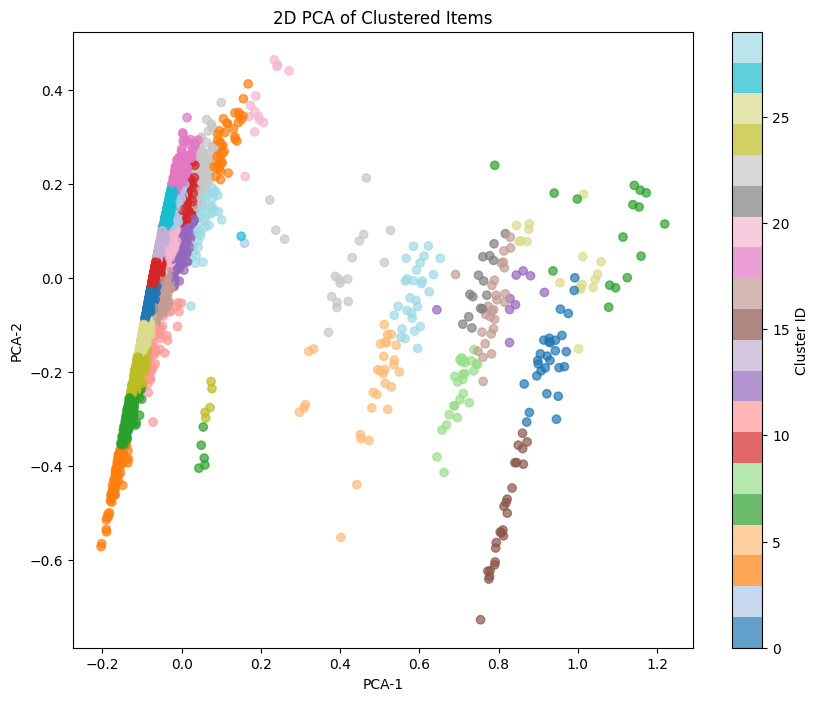

In [73]:
from sklearn.decomposition import PCA

def plot_clusters_pca(score_df, cluster_col='cluster_label', feature_cols=['intensity', 'pop', 'relevance']):

    import matplotlib.pyplot as plt
    
    # Prepare data
    X = score_df[feature_cols].values
    labels = score_df[cluster_col].values
    
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        c=labels,
        cmap='tab20',
        alpha=0.7
    )
    plt.colorbar(scatter, label="Cluster ID")
    plt.xlabel("PCA-1")
    plt.ylabel("PCA-2")
    plt.title("2D PCA of Clustered Items")
    plt.show()

plot_clusters_pca(score_df, cluster_col='cluster_label', feature_cols=['intensity','pop','relevance'])


In [74]:
def is_item_critical_for_exclusion(
    df, svd, group_user_ids, all_movie_ids, popularity_dict, target_item, item_to_remove, N=10
):
    remaining_items = [m for m in all_movie_ids if m != item_to_remove]

    # Recompute scores without the specific item
    score_df = compute_group_item_score(
        df, svd, group_user_ids, remaining_items, popularity_dict
    )
    top_n_df = get_top_n_recommendations(score_df, N=N)

    return target_item in top_n_df['movie_id'].values

def refine_influential_clusters(
    df, svd, group_user_ids, all_movie_ids, popularity_dict, influential_clusters, target_item, N=10
):
    refined_results = {}

    for cluster_id, cluster_df in influential_clusters.items():
        print(f"\nRefining Influential Cluster {cluster_id}...")
        critical_items = []

        for item in cluster_df['movie_id'].tolist():
            is_critical = is_item_critical_for_exclusion(
                df, svd, group_user_ids, all_movie_ids, popularity_dict, target_item, item, N=N
            )

            if is_critical:
                critical_items.append(item)
                print(f"  Critical Item Found: {item}")

        if len(critical_items) > 4:
            print(f"  More than 4 critical items found for cluster {cluster_id}, reducing...")
            critical_items = critical_items[:4]

        refined_results[cluster_id] = critical_items

    return refined_results

def generate_recommendations(df, svd, group_user_ids, all_movie_ids, popularity_dict, N=10):
    score_df = compute_group_item_score(df, svd, group_user_ids, all_movie_ids, popularity_dict)
    top_n_df = get_top_n_recommendations(score_df, N=N)
    return top_n_df

if __name__ == "__main__":
    # Results storage
    refined_items_per_group = {}

    # Process similar groups
    for group_idx, group_user_ids in enumerate(similar_groups):
        print(f"\nProcessing Similar Group {group_idx + 1}...")

        # Compute item scores for the group
        score_df = compute_group_item_score(
            df, svd, group_user_ids, all_movie_ids, popularity_dict
        )

        # Dynamically determine the target item
        target_item = score_df.sort_values(by='item_score', ascending=False).iloc[0]['movie_id']
        print(f"Target item for Similar Group {group_idx + 1}: {target_item}")

        # Refine clusters for the group
        refined_clusters = cluster_items_refined(
            score_df,
            feature_cols=['intensity', 'pop', 'relevance'],
            init_n_clusters=30,
            max_cluster_size=50,
            min_cluster_size=5,
            random_state=42
        )

        # Identify influential clusters
        inf_clusters = identify_influential_clusters(
            df=df,
            svd=svd,
            group_user_ids=group_user_ids,
            all_movie_ids=all_movie_ids,
            popularity_dict=popularity_dict,
            clusters_dict=refined_clusters,
            target_item=target_item,
            N=10
        )

        # Refine influential clusters
        critical_items = refine_influential_clusters(
            df=df,
            svd=svd,
            group_user_ids=group_user_ids,
            all_movie_ids=all_movie_ids,
            popularity_dict=popularity_dict,
            influential_clusters={cid: refined_clusters[cid] for cid in inf_clusters},
            target_item=target_item,
            N=10
        )

        # Store results
        refined_items_per_group[f"similar_group_{group_idx + 1}"] = critical_items

        # Generate old and new recommendations
        old_recommendations = generate_recommendations(df, svd, group_user_ids, all_movie_ids, popularity_dict, N=10)
        print("Old Recommendations:", old_recommendations['movie_id'].tolist())

        # Generate new recommendations without critical items
        remaining_items = [m for m in all_movie_ids if m not in sum(critical_items.values(), [])]
        new_recommendations = generate_recommendations(df, svd, group_user_ids, remaining_items, popularity_dict, N=10)
        print("New Recommendations:", new_recommendations['movie_id'].tolist())

    # Repeat for dissimilar groups
    for group_idx, group_user_ids in enumerate(dissimilar_groups):
        print(f"\nProcessing Dissimilar Group {group_idx + 1}...")

        # Compute item scores for the group
        score_df = compute_group_item_score(
            df, svd, group_user_ids, all_movie_ids, popularity_dict
        )

        # Dynamically determine the target item
        target_item = score_df.sort_values(by='item_score', ascending=False).iloc[0]['movie_id']
        print(f"Target item for Dissimilar Group {group_idx + 1}: {target_item}")

        # Refine clusters for the group
        refined_clusters = cluster_items_refined(
            score_df,
            feature_cols=['intensity', 'pop', 'relevance'],
            init_n_clusters=30,
            max_cluster_size=50,
            min_cluster_size=5,
            random_state=42
        )

        # Identify influential clusters
        inf_clusters = identify_influential_clusters(
            df=df,
            svd=svd,
            group_user_ids=group_user_ids,
            all_movie_ids=all_movie_ids,
            popularity_dict=popularity_dict,
            clusters_dict=refined_clusters,
            target_item=target_item,
            N=10
        )

        # Refine influential clusters
        critical_items = refine_influential_clusters(
            df=df,
            svd=svd,
            group_user_ids=group_user_ids,
            all_movie_ids=all_movie_ids,
            popularity_dict=popularity_dict,
            influential_clusters={cid: refined_clusters[cid] for cid in inf_clusters},
            target_item=target_item,
            N=10
        )

        # Store results
        refined_items_per_group[f"dissimilar_group_{group_idx + 1}"] = critical_items

        # Generate old and new recommendations
        old_recommendations = generate_recommendations(df, svd, group_user_ids, all_movie_ids, popularity_dict, N=10)
        print("Old Recommendations:", old_recommendations['movie_id'].tolist())

        # Generate new recommendations without critical items
        remaining_items = [m for m in all_movie_ids if m not in sum(critical_items.values(), [])]
        new_recommendations = generate_recommendations(df, svd, group_user_ids, remaining_items, popularity_dict, N=10)
        print("New Recommendations:", new_recommendations['movie_id'].tolist())



Processing Similar Group 1...
Target item for Similar Group 1: 260.0

Refining Influential Cluster 26...
  Critical Item Found: 1197
  Critical Item Found: 527
  Critical Item Found: 2762
  Critical Item Found: 2028
  Critical Item Found: 608
  Critical Item Found: 1210
  Critical Item Found: 110
  Critical Item Found: 589
  Critical Item Found: 2858
  Critical Item Found: 1196
  Critical Item Found: 1198
  Critical Item Found: 593
  Critical Item Found: 2571
  Critical Item Found: 318
  Critical Item Found: 858
  More than 4 critical items found for cluster 26, reducing...
Old Recommendations: [260, 2858, 1196, 1198, 2028, 1210, 858, 1197, 2571, 1617]
New Recommendations: [260, 2858, 1196, 1198, 1210, 858, 2571, 1617, 50, 110]

Processing Similar Group 2...
Target item for Similar Group 2: 2571.0

Refining Influential Cluster 45...
  Critical Item Found: 2762
  Critical Item Found: 3578
  Critical Item Found: 1610
  Critical Item Found: 110
  Critical Item Found: 457
  Critical Item 

In [ ]:
import numpy as np
import pandas as pd

def compute_group_fairness(df, group_user_ids, explanation_items):
    """
    Compute the fairness metric for a given group, based on which items are removed (explanation items).
    
    Parameters:
    - df: original ratings DataFrame (with columns 'user_id', 'movie_id', 'rating', etc.)
    - group_user_ids: list of user IDs in the group
    - explanation_items: list of critical items (or the minimal subset) that gets removed
    
    Returns:
    - fairness: float indicating how evenly the removal affects the group (std. dev. of intensities)
    - user_intensity_dict: dictionary mapping user_id -> user_intensity
    """
    user_intensity_dict = {}
    
    # For each user, measure how many explanation_items they rated
    for user_id in group_user_ids:
        user_ratings = df[df['user_id'] == user_id]
        # Intersection with explanation_items
        interacted_items = user_ratings[user_ratings['movie_id'].isin(explanation_items)]
        # Intensity is the fraction of explanation_items the user has interacted with
        intensity = len(interacted_items) / len(explanation_items) if len(explanation_items) > 0 else 0
        user_intensity_dict[user_id] = intensity
    
    # Fairness: standard deviation of intensities across users
    intensities = list(user_intensity_dict.values())
    fairness = np.std(intensities)
    
    return fairness, user_intensity_dict

def compute_fairness_for_all_groups(df, refined_items_per_group, similar_groups, dissimilar_groups):
    """
    Aggregates fairness metrics for each group (similar and dissimilar).
    
    Parameters:
    - df: original DataFrame
    - refined_items_per_group: dictionary like {'similar_group_1': {cluster_id: [items], ...}, ...}
    - similar_groups: list of user lists for similar groups
    - dissimilar_groups: list of user lists for dissimilar groups
    
    Returns:
    - fairness_records: list of dictionaries with fairness metrics
    """
    fairness_records = []
    
    for group_key, cluster_dict in refined_items_per_group.items():
        # Identify the group type and index
        parts = group_key.split('_')  # e.g., "similar_group_1"
        group_type = parts[0]   # "similar" or "dissimilar"
        group_num = int(parts[-1]) - 1
        
        # Retrieve group_user_ids
        if group_type == 'similar':
            group_user_ids = similar_groups[group_num]
        else:
            group_user_ids = dissimilar_groups[group_num]
        
        # Each cluster_id => critical items
        for cluster_id, item_list in cluster_dict.items():
            # Compute fairness for these explanation items
            fairness, intensity_dict = compute_group_fairness(df, group_user_ids, item_list)
            
            fairness_records.append({
                'Group_ID': group_key,
                'Group_Type': group_type.capitalize(),
                'Cluster_ID': cluster_id,
                'Explanation_Size': len(item_list),
                'Fairness': fairness
            })
    
    return fairness_records

# Example usage:
fairness_records = compute_fairness_for_all_groups(df, refined_items_per_group, similar_groups, dissimilar_groups)
fairness_df = pd.DataFrame(fairness_records)
print(fairness_df)


               Group_ID  Group_Type  Cluster_ID  Explanation_Size  Fairness
0       similar_group_1     Similar          26                 4  0.339116
1       similar_group_2     Similar          45                 4  0.122474
2       similar_group_3     Similar          82                 4  0.200000
3       similar_group_4     Similar          37                 4  0.122474
4       similar_group_5     Similar          37                 4  0.158114
..                  ...         ...         ...               ...       ...
95  dissimilar_group_46  Dissimilar          87                 4  0.387298
96  dissimilar_group_47  Dissimilar          19                 4  0.273861
97  dissimilar_group_48  Dissimilar          44                 4  0.187083
98  dissimilar_group_49  Dissimilar          37                 4  0.291548
99  dissimilar_group_50  Dissimilar          20                 4  0.187083

[100 rows x 5 columns]


The boxplot compares the fairness of explanation distributions across similar and dissimilar groups.

Similar Groups:

Tend to have lower fairness variability (tighter distribution).
Median fairness is lower compared to dissimilar groups.
Implication: Similar groups are more uniformly impacted by the removal of explanation items, likely because their preferences align closely.
Dissimilar Groups:

Higher variability in fairness (wider spread in the boxplot).
Median fairness is higher.
Implication: Dissimilar groups are more unevenly impacted, reflecting their diverse preferences—removal of items affects users differently.


C:\Users\immer\AppData\Local\Temp\ipykernel_23264\1547002690.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group_Type', y='Fairness', data=fairness_df, palette='Set2')


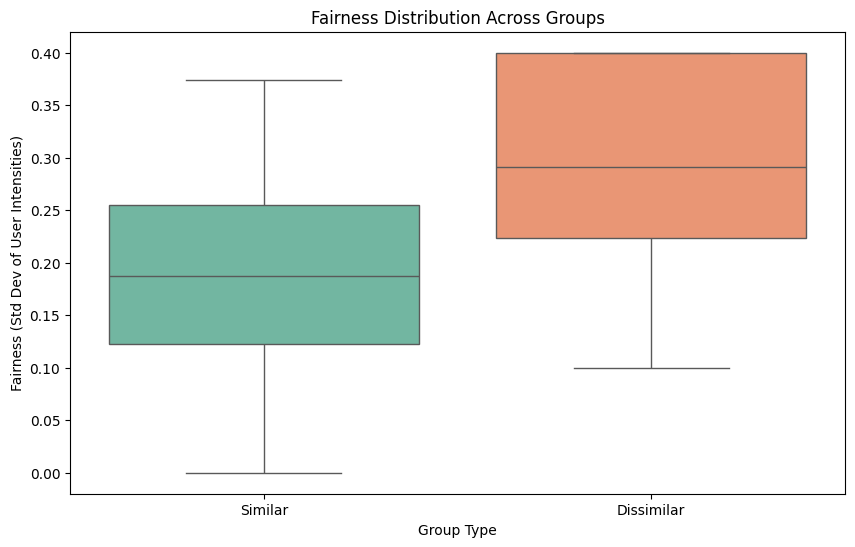

C:\Users\immer\AppData\Local\Temp\ipykernel_23264\1547002690.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Group Type')


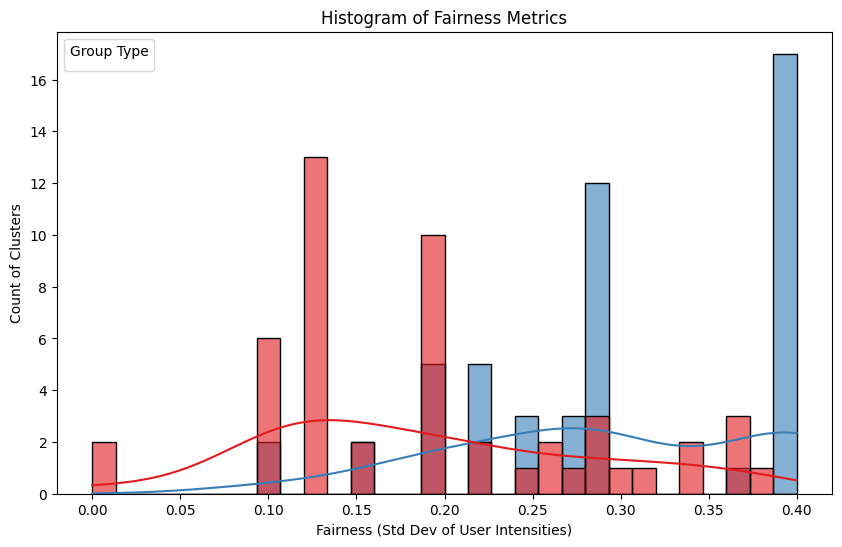

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_fairness_distribution(fairness_df):
    """
    Plot the fairness distribution for both Similar and Dissimilar groups.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Group_Type', y='Fairness', data=fairness_df, palette='Set2')
    plt.title('Fairness Distribution Across Groups')
    plt.xlabel('Group Type')
    plt.ylabel('Fairness (Std Dev of User Intensities)')
    plt.savefig('fairness_distribution.png', dpi=300)
    plt.show()

    # Optionally, show a histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(data=fairness_df, x='Fairness', hue='Group_Type', bins=30, kde=True, palette='Set1', alpha=0.6)
    plt.title('Histogram of Fairness Metrics')
    plt.xlabel('Fairness (Std Dev of User Intensities)')
    plt.ylabel('Count of Clusters')
    plt.legend(title='Group Type')
    plt.savefig('fairness_histogram.png', dpi=300)
    plt.show()

# Example usage:
plot_fairness_distribution(fairness_df)


In [77]:
def find_minimal_explanation_subsets(
    df,
    svd,
    group_user_ids,
    all_movie_ids,
    popularity_dict,
    cluster_item_ids,
    target_item,
    N=10
):
    iteration_log = {'checks': 0}  # dictionary to store iteration counts, checks, etc.

    if not is_item_in_top_n(
        df, svd, group_user_ids, all_movie_ids, popularity_dict,
        target_item, N=N, removed_item_ids=cluster_item_ids
    ):
        cluster_item_ids = list(cluster_item_ids)
        results = []
        best_size = len(cluster_item_ids) + 1

        def backtrack(start, current_subset):
            iteration_log['checks'] += 1  # increment on each check or recursive call

            if not is_item_in_top_n(
                df, svd, group_user_ids, all_movie_ids, popularity_dict,
                target_item, N=N, removed_item_ids=current_subset
            ):
                if len(current_subset) < best_size:
                    results.clear()
                    results.append(list(current_subset))
                elif len(current_subset) == best_size:
                    results.append(list(current_subset))
                return

            for i in range(start, len(cluster_item_ids)):
                if len(current_subset) + 1 > best_size:
                    break
                current_subset.append(cluster_item_ids[i])
                backtrack(i+1, current_subset)
                current_subset.pop()

        backtrack(0, [])
        return results, iteration_log['checks']
    else:
        return [], 0


In [ ]:
def compute_group_item_scores_with_weights(
    df,
    svd,
    group_user_ids,
    all_movie_ids,
    popularity_dict,
    weight_grids=[(0.2, 0.5, 0.3), (0.3, 0.4, 0.3), (0.1, 0.6, 0.3)]
):
    """
    For demonstration, vary the weight schemes and observe changes in top-N items.
    
    weight_grids: list of tuples (w_intensity, w_pop, w_relevance)
    """
    results = []
    for (w_int, w_pop, w_rel) in weight_grids:
        score_df = compute_group_item_score(
            df, svd, group_user_ids, all_movie_ids, popularity_dict,
            w_intensity=w_int, w_pop=w_pop, w_relevance=w_rel
        )
        top_n = get_top_n_recommendations(score_df, N=10)
        top_n_items = top_n['movie_id'].tolist()
        results.append({
            'Weights': (w_int, w_pop, w_rel),
            'Top_10': top_n_items
        })
    return results

def analyze_weight_variation(df, svd, group_user_ids, all_movie_ids, popularity_dict, weight_grids):
    weight_results = compute_group_item_scores_with_weights(
        df, svd, group_user_ids, all_movie_ids, popularity_dict, weight_grids
    )
    
    # Calculate overlap among top-10 under different weight schemes
    all_items_sets = [set(res['Top_10']) for res in weight_results]
    pairwise_overlaps = []

    for i in range(len(all_items_sets)):
        for j in range(i+1, len(all_items_sets)):
            overlap = len(all_items_sets[i].intersection(all_items_sets[j]))
            pairwise_overlaps.append({
                'Weights1': weight_results[i]['Weights'],
                'Weights2': weight_results[j]['Weights'],
                'Overlap': overlap
            })
    return weight_results, pairwise_overlaps

# Example usage for a single group
weight_grids = [
    (0.2, 0.5, 0.3),
    (0.3, 0.3, 0.4),
    (0.4, 0.4, 0.2),
    (0.1, 0.5, 0.4)
]
group_user_ids = similar_groups[0]  # e.g., first similar group
weight_res, overlap_stats = analyze_weight_variation(
    df, svd, group_user_ids, all_movie_ids, popularity_dict, weight_grids
)
print(weight_res)
print(overlap_stats)


[{'Weights': (0.2, 0.5, 0.3), 'Top_10': [2858, 260, 1196, 1210, 2028, 1198, 2571, 1197, 2762, 858]}, {'Weights': (0.3, 0.3, 0.4), 'Top_10': [260, 2858, 1196, 1198, 2028, 858, 1197, 2571, 1210, 527]}, {'Weights': (0.4, 0.4, 0.2), 'Top_10': [2858, 260, 1196, 1210, 1198, 2028, 2571, 1197, 1617, 858]}, {'Weights': (0.1, 0.5, 0.4), 'Top_10': [2858, 260, 1196, 1210, 2028, 1198, 2571, 2762, 1197, 858]}]
[{'Weights1': (0.2, 0.5, 0.3), 'Weights2': (0.3, 0.3, 0.4), 'Overlap': 9}, {'Weights1': (0.2, 0.5, 0.3), 'Weights2': (0.4, 0.4, 0.2), 'Overlap': 9}, {'Weights1': (0.2, 0.5, 0.3), 'Weights2': (0.1, 0.5, 0.4), 'Overlap': 10}, {'Weights1': (0.3, 0.3, 0.4), 'Weights2': (0.4, 0.4, 0.2), 'Overlap': 9}, {'Weights1': (0.3, 0.3, 0.4), 'Weights2': (0.1, 0.5, 0.4), 'Overlap': 9}, {'Weights1': (0.4, 0.4, 0.2), 'Weights2': (0.1, 0.5, 0.4), 'Overlap': 9}]


In [34]:
def find_minimal_explanation_subsets_refined(
    df,
    svd,
    group_user_ids,
    all_movie_ids,
    popularity_dict,
    cluster_item_ids,
    target_item,
    N=10
):
    # 0) Preliminary check: if removing the entire cluster does NOT exclude the target, no smaller subset can do it
    if is_item_in_top_n(
        df, svd, group_user_ids, all_movie_ids, popularity_dict, 
        target_item, N=N, removed_item_ids=cluster_item_ids
    ):
        # Entire cluster removal fails => no subset will exclude
        return [], 0

    # Convert to list for consistent handling
    cluster_item_ids = list(cluster_item_ids)

    # 1) Prioritize items by descending "user intensity" (or another heuristic)
    #    Heuristic: how many users in group have interacted with each item (i.e., rating > 0).
    item_intensity_map = {}
    group_df = df[df['user_id'].isin(group_user_ids)]
    for item in cluster_item_ids:
        # how many users in the group rated this item?
        interacted_count = group_df[group_df['movie_id'] == item].shape[0]
        item_intensity_map[item] = interacted_count

    # Sort cluster items by descending item_intensity (most "impactful" first)
    cluster_item_ids.sort(key=lambda x: item_intensity_map[x], reverse=True)

    # 2) We do a refined backtracking with bounding
    results = []
    best_size = len(cluster_item_ids) + 1
    iteration_count = 0

    def backtrack(start_index, current_subset):
        nonlocal best_size, iteration_count

        iteration_count += 1

        # If removing current_subset excludes the target => potential solution
        if not is_item_in_top_n(
            df, svd, group_user_ids, all_movie_ids, popularity_dict, 
            target_item, N=N, removed_item_ids=current_subset
        ):
            # Found a subset that excludes target
            subset_size = len(current_subset)
            if subset_size < best_size:
                best_size = subset_size
                results.clear()
                results.append(list(current_subset))
            elif subset_size == best_size:
                results.append(list(current_subset))
            return

        # If current subset is already as large as best known, no need to continue
        if len(current_subset) >= best_size:
            return

        # Pruning: if we have no more items to add, stop
        for i in range(start_index, len(cluster_item_ids)):
            # If adding one more item would exceed best_size, prune
            if len(current_subset) + 1 > best_size:
                break

            current_subset.append(cluster_item_ids[i])
            backtrack(i + 1, current_subset)
            current_subset.pop()

    # 3) Run the refined backtracking
    backtrack(0, [])

    return results, iteration_count


In [39]:
def refine_influential_clusters(
    df, svd, group_user_ids, all_movie_ids, popularity_dict, influential_clusters, target_item, N=10
):
    refined_results = {}

    for cluster_id, cluster_df in influential_clusters.items():
        print(f"\nRefining Influential Cluster {cluster_id}...")
        critical_items = []

        for item in cluster_df['movie_id'].tolist():
            is_critical = is_item_critical_for_exclusion(
                df, svd, group_user_ids, all_movie_ids, popularity_dict, target_item, item, N=N
            )

            if is_critical:
                critical_items.append(item)
                print(f"  explanation Found: {item}")
            
            # Stop processing more items if we already have 4 critical items
            if len(critical_items) >= 4:
                break

        refined_results[cluster_id] = critical_items

    return refined_results


In [40]:
def is_item_critical_for_exclusion(
    df, svd, group_user_ids, all_movie_ids, popularity_dict, target_item, item_to_remove, N=10
):
    remaining_items = [m for m in all_movie_ids if m != item_to_remove]

    # Recompute scores without the specific item
    score_df = compute_group_item_score(
        df, svd, group_user_ids, remaining_items, popularity_dict
    )
    top_n_df = get_top_n_recommendations(score_df, N=N)

    is_critical = target_item in top_n_df['movie_id'].values

    # Debugging output
    print(f"Item Removed: {item_to_remove}, Result in Target removal: {is_critical}")
    return is_critical



In [ ]:
if __name__ == "__main__":
    # Results storage
    refined_items_per_group = {}

    # Process similar groups
    for group_idx, group_user_ids in enumerate(similar_groups):
        print(f"\nProcessing Similar Group {group_idx + 1}...")

        # Compute item scores for the group
        score_df = compute_group_item_score(
            df, svd, group_user_ids, all_movie_ids, popularity_dict
        )

        # Dynamically determine the target item
        target_item = score_df.sort_values(by='item_score', ascending=False).iloc[0]['movie_id']
        print(f"Target item for Similar Group {group_idx + 1}: {target_item}")

        # Refine clusters for the group
        refined_clusters = cluster_items_refined(
            score_df,
            feature_cols=['intensity', 'pop', 'relevance'],
            init_n_clusters=30,
            max_cluster_size=50,
            min_cluster_size=5,
            random_state=42
        )

        # Identify influential clusters
        inf_clusters = identify_influential_clusters(
            df=df,
            svd=svd,
            group_user_ids=group_user_ids,
            all_movie_ids=all_movie_ids,
            popularity_dict=popularity_dict,
            clusters_dict=refined_clusters,
            target_item=target_item,
            N=10
        )

        # Refine influential clusters
        critical_items = refine_influential_clusters(
            df=df,
            svd=svd,
            group_user_ids=group_user_ids,
            all_movie_ids=all_movie_ids,
            popularity_dict=popularity_dict,
            influential_clusters={cid: refined_clusters[cid] for cid in inf_clusters},
            target_item=target_item,
            N=10
        )

        # Store results
        refined_items_per_group[f"similar_group_{group_idx + 1}"] = critical_items

        # Generate old and new recommendations
        old_recommendations = generate_recommendations(df, svd, group_user_ids, all_movie_ids, popularity_dict, N=10)
        print("Old Recommendations:", old_recommendations['movie_id'].tolist())

        # Generate new recommendations without critical items
        remaining_items = [m for m in all_movie_ids if m not in sum(critical_items.values(), [])]
        new_recommendations = generate_recommendations(df, svd, group_user_ids, remaining_items, popularity_dict, N=10)
        print("New Recommendations:", new_recommendations['movie_id'].tolist())

    # Repeat for dissimilar groups
    for group_idx, group_user_ids in enumerate(dissimilar_groups):
        print(f"\nProcessing Dissimilar Group {group_idx + 1}...")

        # Compute item scores for the group
        score_df = compute_group_item_score(
            df, svd, group_user_ids, all_movie_ids, popularity_dict
        )

        # Dynamically determine the target item
        target_item = score_df.sort_values(by='item_score', ascending=False).iloc[0]['movie_id']
        print(f"Target item for Dissimilar Group {group_idx + 1}: {target_item}")

        # Refine clusters for the group
        refined_clusters = cluster_items_refined(
            score_df,
            feature_cols=['intensity', 'pop', 'relevance'],
            init_n_clusters=30,
            max_cluster_size=50,
            min_cluster_size=5,
            random_state=42
        )

        # Identify influential clusters
        inf_clusters = identify_influential_clusters(
            df=df,
            svd=svd,
            group_user_ids=group_user_ids,
            all_movie_ids=all_movie_ids,
            popularity_dict=popularity_dict,
            clusters_dict=refined_clusters,
            target_item=target_item,
            N=10
        )

        # Refine influential clusters
        critical_items = refine_influential_clusters(
            df=df,
            svd=svd,
            group_user_ids=group_user_ids,
            all_movie_ids=all_movie_ids,
            popularity_dict=popularity_dict,
            influential_clusters={cid: refined_clusters[cid] for cid in inf_clusters},
            target_item=target_item,
            N=10
        )

        # Store results
        refined_items_per_group[f"dissimilar_group_{group_idx + 1}"] = critical_items

        # Generate old and new recommendations
        old_recommendations = generate_recommendations(df, svd, group_user_ids, all_movie_ids, popularity_dict, N=10)
        print("Old Recommendations:", old_recommendations['movie_id'].tolist())

        # Generate new recommendations without critical items
        remaining_items = [m for m in all_movie_ids if m not in sum(critical_items.values(), [])]
        new_recommendations = generate_recommendations(df, svd, group_user_ids, remaining_items, popularity_dict, N=10)
        print("New Recommendations:", new_recommendations['movie_id'].tolist())



Processing Similar Group 1...
Target item for Similar Group 1: 2858.0

Refining Influential Cluster 32...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [2858, 260, 1196, 2028, 593, 1198, 2571, 858, 527, 2762]
New Recommendations: [2858, 260, 1196, 2028, 593, 1198, 2571, 858, 2762, 318]

Processing Similar Group 2...
Target item for Similar Group 2: 2858.0

Refining Influential Cluster 47...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendation

KeyboardInterrupt: 

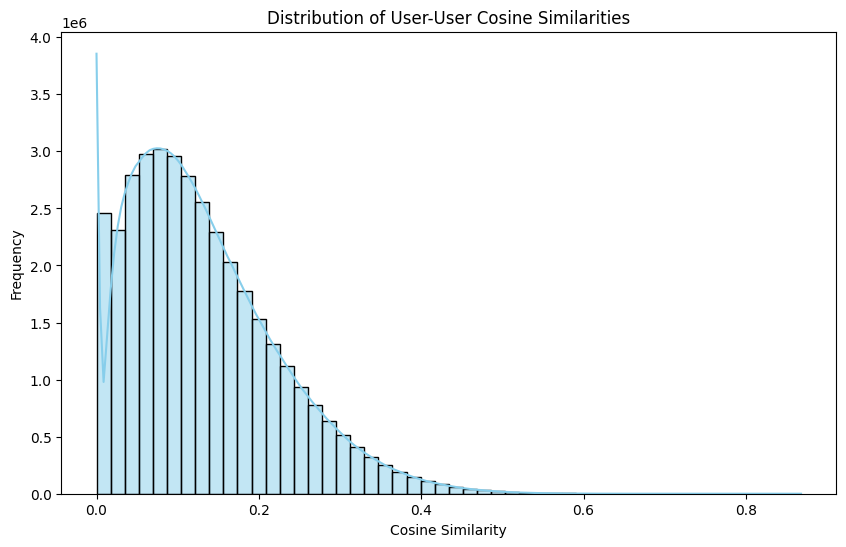

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten the similarity matrix and remove self-similarities (diagonal)
similarity_values = sim_matrix.flatten()
n_users = len(user_ids)
similarity_values = np.delete(similarity_values, np.arange(0, n_users * n_users, n_users + 1))

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(similarity_values, bins=50, kde=True, color='skyblue')
plt.title('Distribution of User-User Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.savefig('user_similarity_distribution.png', dpi=300)
plt.show()


C:\Users\immer\AppData\Local\Temp\ipykernel_23264\1178169081.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group_Type', y='Cluster_Size', data=cluster_sizes_df, palette='Set2')


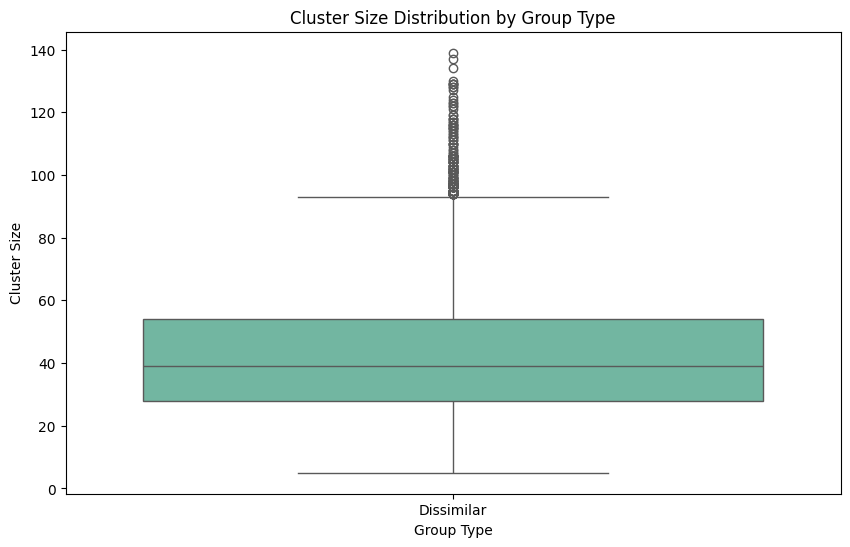

In [106]:
# Compile cluster sizes for all groups
cluster_sizes = []

for group_id, clusters in refined_clusters_all_groups.items():
    group_type = 'Dissimilar' if 'similar' in group_id else 'similar'
    for cid, cluster_df in clusters.items():
        cluster_sizes.append({
            'Group_ID': group_id,
            'Group_Type': group_type,
            'Cluster_Size': len(cluster_df)
        })

cluster_sizes_df = pd.DataFrame(cluster_sizes)

# Plot boxplot of cluster sizes by group type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Group_Type', y='Cluster_Size', data=cluster_sizes_df, palette='Set2')
plt.title('Cluster Size Distribution by Group Type')
plt.xlabel('Group Type')
plt.ylabel('Cluster Size')
plt.savefig('cluster_size_distribution.png', dpi=300)
plt.show()


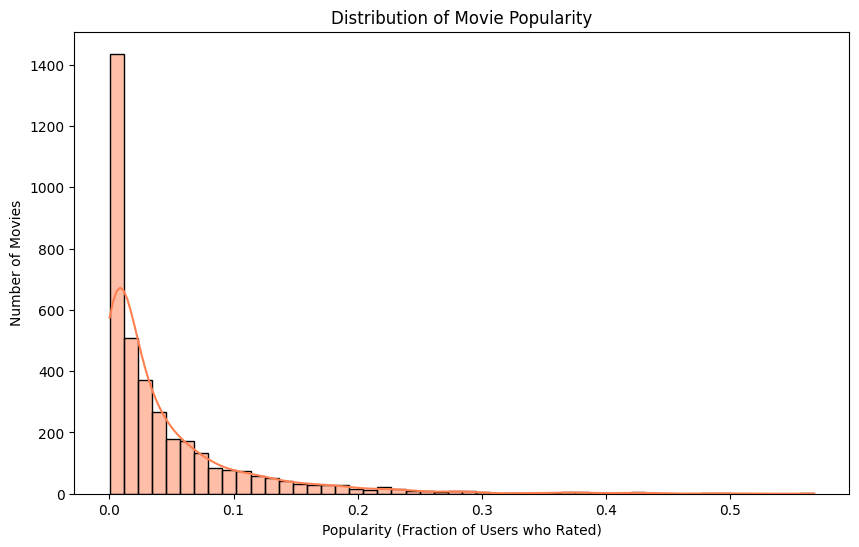

In [ ]:
# Convert popularity_dict to DataFrame
popularity_df = pd.DataFrame(list(popularity_dict.items()), columns=['movie_id', 'popularity'])

# Plot histogram of item popularity
plt.figure(figsize=(10, 6))
sns.histplot(popularity_df['popularity'], bins=50, kde=True, color='coral')
plt.title('Distribution of Movie Popularity')
plt.xlabel('Popularity (Fraction of Users who Rated)')
plt.ylabel('Number of Movies')
plt.savefig('movie_popularity_distribution.png', dpi=300)
plt.show()


In [ ]:
# Compile cluster sizes for all groups
cluster_sizes = []

for group_id, clusters in refined_clusters_all_groups.items():
    group_type = 'Similar' if 'similar' in group_id else 'Dissimilar'
    for cid, cluster_df in clusters.items():
        cluster_sizes.append({
            'Group_ID': group_id,
            'Group_Type': group_type,
            'Cluster_Size': len(cluster_df)
        })

cluster_sizes_df = pd.DataFrame(cluster_sizes)

# Filter data for dissimilar groups only
dissimilar_group_sizes_df = cluster_sizes_df[cluster_sizes_df['Group_Type'] == 'Dissimilar']

# Plot boxplot for dissimilar group cluster sizes
plt.figure(figsize=(10, 6))
sns.boxplot(x='Group_Type', y='Cluster_Size', data=dissimilar_group_sizes_df, palette='coolwarm')
plt.title('Cluster Size Distribution for Dissimilar Groups')
plt.xlabel('Group Type')
plt.ylabel('Cluster Size')
plt.savefig('dissimilar_group_cluster_size_distribution.png', dpi=300)
plt.show()


In [53]:
def compute_fairness_for_all_groups(df, refined_items_per_group, similar_groups, dissimilar_groups):
    """
    Aggregates fairness metrics for each group (similar and dissimilar).
    """
    fairness_records = []

    # Debugging: Print refined_items_per_group structure
    print("\nRefined Items Per Group:")
    for group_key, cluster_dict in refined_items_per_group.items():
        print(f"Group: {group_key}, Clusters: {list(cluster_dict.keys())}")

    for group_key, cluster_dict in refined_items_per_group.items():
        parts = group_key.split('_')  # e.g., "similar_group_1"
        group_type = parts[0]  # "similar" or "dissimilar"
        group_num = int(parts[-1]) - 1
        
        # Retrieve group_user_ids
        if group_type == 'similar':
            group_user_ids = similar_groups[group_num]
        elif group_type == 'dissimilar':
            group_user_ids = dissimilar_groups[group_num]
        else:
            continue  # Skip invalid group types

        for cluster_id, item_list in cluster_dict.items():
            if not item_list:
                continue  # Skip empty explanations
            fairness, intensity_dict = compute_group_fairness(df, group_user_ids, item_list)
            fairness_records.append({
                'Group_ID': group_key,
                'Group_Type': group_type.capitalize(),
                'Cluster_ID': cluster_id,
                'Explanation_Size': len(item_list),
                'Fairness': fairness
            })

    return fairness_records

# Recompute fairness metrics
fairness_records = compute_fairness_for_all_groups(df, refined_items_per_group, similar_groups, dissimilar_groups)

# Create a DataFrame for analysis
fairness_df = pd.DataFrame(fairness_records)

# Filter and print fairness metrics for similar groups
similar_fairness_df = fairness_df[fairness_df['Group_Type'] == 'Similar']
print("\nFairness Metrics for Similar Groups:")
print(similar_fairness_df)

# Filter and print fairness metrics for dissimilar groups
dissimilar_fairness_df = fairness_df[fairness_df['Group_Type'] == 'Dissimilar']
print("\nFairness Metrics for Dissimilar Groups:")
print(dissimilar_fairness_df)

# Combined fairness metrics
print("\nCombined Fairness Metrics for All Groups:")
print(fairness_df)



Refined Items Per Group:
Group: similar_group_1, Clusters: [32]
Group: similar_group_2, Clusters: [47]
Group: similar_group_3, Clusters: [84]
Group: similar_group_4, Clusters: [30]
Group: similar_group_5, Clusters: [77]
Group: similar_group_6, Clusters: [31]
Group: similar_group_7, Clusters: [75]
Group: similar_group_8, Clusters: [35]
Group: similar_group_9, Clusters: [27]
Group: similar_group_10, Clusters: [22]
Group: similar_group_11, Clusters: [14]
Group: similar_group_12, Clusters: [68]
Group: similar_group_13, Clusters: [25]
Group: similar_group_14, Clusters: [43]
Group: similar_group_15, Clusters: [22]
Group: similar_group_16, Clusters: [36]
Group: similar_group_17, Clusters: [28]
Group: similar_group_18, Clusters: [26]
Group: similar_group_19, Clusters: [31]
Group: similar_group_20, Clusters: [25]
Group: similar_group_21, Clusters: [23]
Group: similar_group_22, Clusters: [25]
Group: similar_group_23, Clusters: [42]
Group: similar_group_24, Clusters: [13]
Group: similar_group_25

# result for
# w_intensity=0.2, w_pop=0.2, w_relevance=0.6
Processing Similar Group 1...
Target item for Similar Group 1: 2858.0

Refining Influential Cluster 27...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [2858, 260, 1196, 296, 608, 858, 1198, 593, 2028, 318]
New Recommendations: [2858, 260, 1196, 296, 608, 858, 1198, 593, 2028, 318]

Processing Similar Group 2...
Target item for Similar Group 2: 858.0

Refining Influential Cluster 65...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 2355, Result in Target removal: True
  explanation Found: 2355
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 919, Result in Target removal: True
  explanation Found: 919
Old Recommendations: [858, 2858, 608, 296, 1198, 260, 1197, 593, 1214, 912]
New Recommendations: [858, 2858, 608, 296, 1198, 260, 593, 1214, 912, 1213]

Processing Similar Group 3...
Target item for Similar Group 3: 260.0

Refining Influential Cluster 14...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Item Removed: 110, Result in Target removal: True
  explanation Found: 110
Old Recommendations: [260, 2571, 1196, 2028, 589, 1198, 110, 3578, 858, 1210]
New Recommendations: [260, 2571, 1196, 589, 1198, 3578, 858, 541, 296, 1240]

Processing Similar Group 4...
Target item for Similar Group 4: 2858.0

Refining Influential Cluster 37...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [2858, 296, 858, 608, 593, 318, 2028, 2997, 527, 1221]
New Recommendations: [2858, 296, 858, 608, 593, 318, 2028, 2997, 1221, 1196]

Processing Similar Group 5...
Target item for Similar Group 5: 2858.0

Refining Influential Cluster 47...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [2858, 318, 593, 260, 296, 858, 527, 1196, 2028, 1213]
New Recommendations: [2858, 318, 593, 260, 296, 858, 1196, 2028, 1213, 608]

Processing Similar Group 6...
Target item for Similar Group 6: 2858.0

Refining Influential Cluster 57...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Old Recommendations: [2858, 260, 912, 2762, 1198, 1193, 750, 919, 1207, 2396]
New Recommendations: [2858, 912, 1198, 1193, 750, 919, 1207, 2396, 1196, 913]

Processing Similar Group 7...
Target item for Similar Group 7: 2858.0

Refining Influential Cluster 28...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Old Recommendations: [2858, 296, 858, 608, 318, 2997, 50, 593, 527, 2028]
New Recommendations: [2858, 296, 858, 608, 318, 2997, 50, 593, 2028, 1213]

Processing Similar Group 8...
Target item for Similar Group 8: 260.0

Refining Influential Cluster 71...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 260, Result in Target removal: False
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Item Removed: 3578, Result in Target removal: True
  explanation Found: 3578
Item Removed: 589, Result in Target removal: True
  explanation Found: 589
Old Recommendations: [260, 1196, 2858, 2571, 1617, 1193, 750, 593, 541, 589]
New Recommendations: [260, 1196, 2858, 2571, 1617, 750, 593, 541, 912, 1200]

Processing Similar Group 9...
Target item for Similar Group 9: 318.0

Refining Influential Cluster 48...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [318, 2571, 50, 2858, 2028, 1136, 593, 260, 589, 2762]
New Recommendations: [318, 2571, 50, 2858, 2028, 1136, 593, 260, 589, 1196]

Processing Similar Group 10...
Target item for Similar Group 10: 260.0

Refining Influential Cluster 8...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Old Recommendations: [260, 1196, 2762, 593, 1198, 2571, 858, 50, 2028, 608]
New Recommendations: [260, 1196, 593, 1198, 2571, 858, 50, 589, 1617, 110]

Processing Similar Group 11...
Target item for Similar Group 11: 2858.0

Refining Influential Cluster 24...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [2858, 260, 1198, 593, 858, 318, 1196, 296, 50, 2028]
New Recommendations: [2858, 260, 1198, 593, 858, 318, 1196, 296, 50, 2028]

Processing Similar Group 12...
Target item for Similar Group 12: 858.0

Refining Influential Cluster 77...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [858, 260, 1198, 2028, 2858, 593, 296, 110, 1196, 1214]
New Recommendations: [858, 260, 1198, 2028, 2858, 593, 296, 110, 1196, 1214]

Processing Similar Group 13...
Target item for Similar Group 13: 318.0

Refining Influential Cluster 86...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [318, 2396, 527, 1197, 260, 1307, 2762, 593, 1207, 1148]
New Recommendations: [318, 2396, 260, 1307, 2762, 593, 1207, 1148, 919, 2858]

Processing Similar Group 14...
Target item for Similar Group 14: 2762.0

Refining Influential Cluster 83...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: False
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [2762, 260, 2571, 318, 1196, 356, 2028, 110, 1198, 1210]
New Recommendations: [2762, 2571, 318, 1196, 356, 110, 1198, 1210, 589, 593]

Processing Similar Group 15...
Target item for Similar Group 15: 2571.0

Refining Influential Cluster 48...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [2571, 260, 1196, 2762, 589, 110, 1210, 318, 2858, 1198]
New Recommendations: [2571, 260, 1196, 2762, 589, 110, 1210, 318, 2858, 1198]

Processing Similar Group 16...
Target item for Similar Group 16: 2858.0

Refining Influential Cluster 89...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Item Removed: 3578, Result in Target removal: True
  explanation Found: 3578
Old Recommendations: [2858, 858, 1198, 2997, 1197, 2762, 3578, 1210, 1230, 1]
New Recommendations: [2858, 858, 1198, 2997, 1210, 1230, 3897, 223, 2959, 3114]

Processing Similar Group 17...
Target item for Similar Group 17: 2858.0

Refining Influential Cluster 19...
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Old Recommendations: [2858, 318, 2028, 2762, 1196, 527, 593, 2571, 356, 50]
New Recommendations: [2858, 318, 2028, 1196, 593, 2571, 356, 50, 1210, 608]

Processing Similar Group 18...
Target item for Similar Group 18: 260.0

Refining Influential Cluster 32...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [260, 1196, 2858, 527, 318, 858, 2571, 1198, 1197, 1193]
New Recommendations: [260, 1196, 2858, 318, 858, 2571, 1198, 1193, 296, 912]

Processing Similar Group 19...
Target item for Similar Group 19: 2858.0

Refining Influential Cluster 13...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Old Recommendations: [2858, 2997, 527, 1193, 1197, 913, 2959, 1210, 2395, 2791]
New Recommendations: [2858, 2997, 1193, 913, 2959, 2395, 2791, 3160, 2918, 3114]

Processing Similar Group 20...
Target item for Similar Group 20: 260.0

Refining Influential Cluster 47...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [260, 527, 1198, 2762, 1, 1196, 919, 2858, 3114, 318]
New Recommendations: [260, 1198, 2762, 1, 1196, 919, 2858, 3114, 318, 589]

Processing Similar Group 21...
Target item for Similar Group 21: 318.0

Refining Influential Cluster 25...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 919, Result in Target removal: True
  explanation Found: 919
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Old Recommendations: [318, 527, 2762, 912, 2396, 1307, 1035, 1704, 356, 1197]
New Recommendations: [318, 2762, 912, 2396, 1307, 1035, 1704, 356, 1198, 260]

Processing Similar Group 22...
Target item for Similar Group 22: 2858.0

Refining Influential Cluster 46...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [2858, 858, 260, 1198, 912, 2028, 608, 318, 50, 2762]
New Recommendations: [2858, 858, 260, 1198, 912, 2028, 608, 318, 50, 2762]

Processing Similar Group 23...
Target item for Similar Group 23: 1196.0

Refining Influential Cluster 60...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [1196, 2571, 260, 1198, 318, 2858, 110, 1210, 589, 2716]
New Recommendations: [1196, 2571, 260, 1198, 318, 2858, 110, 1210, 589, 2716]

Processing Similar Group 24...
Target item for Similar Group 24: 858.0

Refining Influential Cluster 39...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 2804, Result in Target removal: True
  explanation Found: 2804
Item Removed: 919, Result in Target removal: True
  explanation Found: 919
Item Removed: 1213, Result in Target removal: True
  explanation Found: 1213
Old Recommendations: [858, 608, 923, 912, 2858, 1193, 1221, 750, 1230, 1288]
New Recommendations: [858, 608, 923, 912, 2858, 1221, 750, 1230, 1288, 296]

Processing Similar Group 25...
Target item for Similar Group 25: 608.0

Refining Influential Cluster 58...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 919, Result in Target removal: True
  explanation Found: 919
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Old Recommendations: [608, 2858, 858, 260, 296, 912, 593, 527, 1198, 1193]
New Recommendations: [608, 2858, 858, 260, 296, 912, 593, 1198, 1221, 318]

Processing Similar Group 26...
Target item for Similar Group 26: 2858.0

Refining Influential Cluster 51...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [2858, 608, 593, 858, 1193, 318, 260, 527, 912, 1198]
New Recommendations: [2858, 608, 593, 858, 1193, 318, 260, 912, 1198, 1230]

Processing Similar Group 27...
Target item for Similar Group 27: 260.0

Refining Influential Cluster 51...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [260, 2858, 1196, 296, 1198, 2571, 858, 589, 318, 608]
New Recommendations: [260, 2858, 1196, 296, 1198, 2571, 858, 589, 318, 608]

Processing Similar Group 28...
Target item for Similar Group 28: 2858.0

Refining Influential Cluster 28...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Item Removed: 110, Result in Target removal: True
  explanation Found: 110
Item Removed: 589, Result in Target removal: True
  explanation Found: 589
Old Recommendations: [2858, 858, 110, 1197, 912, 1210, 589, 3578, 1196, 1704]
New Recommendations: [2858, 858, 912, 3578, 1196, 1704, 908, 3897, 1269, 1259]

Processing Similar Group 29...
Target item for Similar Group 29: 2858.0

Refining Influential Cluster 14...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 919, Result in Target removal: True
  explanation Found: 919
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Old Recommendations: [2858, 260, 527, 608, 1198, 1196, 318, 858, 919, 912]
New Recommendations: [2858, 260, 527, 608, 1198, 1196, 318, 858, 912, 1]

Processing Similar Group 30...
Target item for Similar Group 30: 608.0

Refining Influential Cluster 58...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [608, 858, 296, 2858, 912, 260, 750, 1214, 1219, 1198]
New Recommendations: [608, 858, 296, 2858, 912, 260, 750, 1214, 1219, 1198]

Processing Similar Group 31...
Target item for Similar Group 31: 260.0

Refining Influential Cluster 62...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [260, 527, 318, 919, 1198, 1, 3114, 1196, 858, 1270]
New Recommendations: [260, 318, 919, 1198, 1, 3114, 1196, 858, 912, 2028]

Processing Similar Group 32...
Target item for Similar Group 32: 318.0

Refining Influential Cluster 82...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 2858, Result in Target removal: True
  explanation Found: 2858
Old Recommendations: [318, 2858, 2028, 1197, 3578, 593, 913, 2716, 1270, 1097]
New Recommendations: [318, 3578, 593, 2716, 913, 1097, 2355, 912, 260, 1961]

Processing Similar Group 33...
Target item for Similar Group 33: 260.0

Refining Influential Cluster 44...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 260, Result in Target removal: False
Item Removed: 2628, Result in Target removal: True
  explanation Found: 2628
Old Recommendations: [260, 2858, 858, 912, 1198, 589, 1193, 750, 1617, 1196]
New Recommendations: [260, 2858, 858, 912, 1198, 589, 1193, 750, 1617, 1196]

Processing Similar Group 34...
Target item for Similar Group 34: 260.0

Refining Influential Cluster 47...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 260, Result in Target removal: False
Item Removed: 2628, Result in Target removal: True
  explanation Found: 2628
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Old Recommendations: [260, 1196, 2858, 2571, 541, 1210, 912, 750, 589, 908]
New Recommendations: [260, 1196, 2858, 2571, 541, 912, 750, 589, 908, 1200]

Processing Similar Group 35...
Target item for Similar Group 35: 260.0

Refining Influential Cluster 43...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [260, 1198, 1196, 2762, 1197, 527, 1210, 919, 2571, 2028]
New Recommendations: [260, 1198, 1196, 2762, 1210, 919, 2571, 2028, 1, 480]

Processing Similar Group 36...
Target item for Similar Group 36: 260.0

Refining Influential Cluster 22...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [260, 1196, 2858, 2762, 318, 1198, 2028, 593, 1210, 296]
New Recommendations: [260, 1196, 2858, 318, 1198, 593, 1210, 296, 2571, 858]

Processing Similar Group 37...
Target item for Similar Group 37: 260.0

Refining Influential Cluster 29...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [260, 593, 318, 110, 527, 1196, 2858, 2028, 1198, 858]
New Recommendations: [260, 593, 318, 110, 1196, 2858, 2028, 1198, 858, 296]

Processing Similar Group 38...
Target item for Similar Group 38: 2858.0

Refining Influential Cluster 37...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Old Recommendations: [2858, 296, 2997, 50, 608, 527, 1617, 2028, 1265, 1230]
New Recommendations: [2858, 296, 2997, 50, 608, 1617, 2028, 1265, 1230, 912]

Processing Similar Group 39...
Target item for Similar Group 39: 2858.0

Refining Influential Cluster 12...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [2858, 527, 593, 2762, 2997, 260, 913, 1270, 2396, 3114]
New Recommendations: [2858, 593, 2997, 260, 913, 2396, 3114, 3578, 2692, 908]

Processing Similar Group 40...
Target item for Similar Group 40: 260.0

Refining Influential Cluster 84...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [260, 318, 2028, 858, 1198, 2858, 1196, 593, 589, 2762]
New Recommendations: [260, 318, 2028, 858, 1198, 2858, 1196, 593, 589, 2762]

Processing Similar Group 41...
Target item for Similar Group 41: 2858.0

Refining Influential Cluster 31...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [2858, 318, 527, 593, 2028, 1, 1193, 356, 3114, 919]
New Recommendations: [2858, 318, 593, 2028, 1, 1193, 356, 3114, 919, 1307]

Processing Similar Group 42...
Target item for Similar Group 42: 260.0

Refining Influential Cluster 40...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [260, 1198, 2858, 1196, 527, 593, 2762, 1197, 318, 2571]
New Recommendations: [260, 1198, 2858, 1196, 593, 318, 2571, 858, 50, 1240]

Processing Similar Group 43...
Target item for Similar Group 43: 260.0

Refining Influential Cluster 36...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [260, 1198, 858, 1196, 608, 1214, 912, 593, 1221, 296]
New Recommendations: [260, 1198, 858, 1196, 608, 1214, 912, 593, 1221, 296]

Processing Similar Group 44...
Target item for Similar Group 44: 260.0

Refining Influential Cluster 59...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Old Recommendations: [260, 858, 1198, 50, 2028, 296, 608, 2762, 1136, 318]
New Recommendations: [260, 858, 1198, 50, 2028, 296, 608, 2762, 1136, 318]

Processing Similar Group 45...
Target item for Similar Group 45: 593.0

Refining Influential Cluster 7...
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Item Removed: 480, Result in Target removal: True
  explanation Found: 480
Old Recommendations: [593, 260, 2028, 1196, 912, 1214, 541, 1219, 1387, 1278]
New Recommendations: [593, 1196, 912, 1214, 541, 1219, 1387, 1278, 1294, 1997]

Processing Similar Group 46...
Target item for Similar Group 46: 260.0

Refining Influential Cluster 23...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [260, 1196, 1198, 589, 2028, 2571, 110, 2762, 1210, 1197]
New Recommendations: [260, 1196, 1198, 589, 2571, 110, 1210, 1200, 1240, 3578]

Processing Similar Group 47...
Target item for Similar Group 47: 2858.0

Refining Influential Cluster 34...
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Old Recommendations: [2858, 260, 527, 2997, 1210, 2762, 2692, 3578, 913, 912]
New Recommendations: [2858, 2997, 2692, 3578, 913, 912, 223, 2716, 2395, 908]

Processing Similar Group 48...
Target item for Similar Group 48: 260.0

Refining Influential Cluster 70...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [260, 2858, 2571, 1196, 318, 1198, 3578, 110, 1197, 50]
New Recommendations: [260, 2858, 2571, 1196, 318, 1198, 3578, 110, 50, 1210]

Processing Similar Group 49...
Target item for Similar Group 49: 318.0

Refining Influential Cluster 26...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [318, 260, 1198, 527, 2762, 593, 50, 2028, 110, 1196]
New Recommendations: [318, 260, 1198, 593, 50, 2028, 110, 1196, 2571, 3578]

Processing Similar Group 50...
Target item for Similar Group 50: 260.0

Refining Influential Cluster 33...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [260, 527, 2571, 2028, 593, 2858, 858, 110, 2762, 589]
New Recommendations: [260, 2571, 593, 2858, 858, 110, 589, 318, 1196, 50]

Processing Dissimilar Group 1...
Target item for Dissimilar Group 1: 318.0

Refining Influential Cluster 72...
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Item Removed: 110, Result in Target removal: True
  explanation Found: 110
Old Recommendations: [318, 1198, 2762, 110, 2028, 296, 1240, 2997, 1214, 2858]
New Recommendations: [318, 1198, 296, 1240, 2997, 1214, 2858, 589, 2571, 1097]

Processing Dissimilar Group 2...
Target item for Dissimilar Group 2: 2858.0

Refining Influential Cluster 43...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [2858, 260, 318, 50, 2571, 608, 1196, 2762, 1197, 296]
New Recommendations: [2858, 318, 50, 2571, 608, 1196, 1197, 296, 2997, 527]

Processing Dissimilar Group 3...
Target item for Dissimilar Group 3: 260.0

Refining Influential Cluster 49...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [260, 318, 527, 1196, 2762, 1197, 110, 1210, 593, 457]
New Recommendations: [260, 318, 1196, 110, 1210, 593, 457, 589, 356, 2858]

Processing Dissimilar Group 4...
Target item for Dissimilar Group 4: 593.0

Refining Influential Cluster 23...
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Item Removed: 1198, Result in Target removal: True
  explanation Found: 1198
Old Recommendations: [593, 318, 260, 858, 1198, 2571, 912, 2762, 527, 2858]
New Recommendations: [593, 318, 858, 2571, 912, 2762, 527, 2858, 50, 1193]

Processing Dissimilar Group 5...
Target item for Dissimilar Group 5: 260.0

Refining Influential Cluster 34...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [260, 608, 2858, 904, 858, 2762, 2396, 1193, 1207, 1617]
New Recommendations: [260, 608, 2858, 904, 858, 2396, 1193, 1207, 1617, 913]

Processing Dissimilar Group 6...
Target item for Dissimilar Group 6: 2858.0

Refining Influential Cluster 30...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [2858, 318, 527, 1197, 1196, 296, 2028, 912, 1617, 2762]
New Recommendations: [2858, 318, 1196, 296, 2028, 912, 1617, 2396, 2324, 913]

Processing Dissimilar Group 7...
Target item for Dissimilar Group 7: 2762.0

Refining Influential Cluster 8...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 2762, Result in Target removal: False
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Old Recommendations: [2762, 2858, 110, 260, 608, 858, 589, 1617, 1198, 1196]
New Recommendations: [2762, 2858, 110, 858, 589, 1617, 1198, 1196, 2571, 3578]

Processing Dissimilar Group 8...
Target item for Dissimilar Group 8: 260.0

Refining Influential Cluster 24...
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Item Removed: 2858, Result in Target removal: True
  explanation Found: 2858
Item Removed: 1196, Result in Target removal: True
  explanation Found: 1196
Old Recommendations: [260, 1196, 593, 1198, 858, 2858, 2028, 3114, 1, 1240]
New Recommendations: [260, 593, 1198, 858, 1, 1240, 3114, 1214, 1617, 1270]

Processing Dissimilar Group 9...
Target item for Dissimilar Group 9: 260.0

Refining Influential Cluster 22...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [260, 2858, 527, 2028, 858, 1198, 593, 110, 296, 2396]
New Recommendations: [260, 2858, 858, 1198, 593, 110, 296, 2396, 1196, 912]

Processing Dissimilar Group 10...
Target item for Dissimilar Group 10: 260.0

Refining Influential Cluster 9...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [260, 527, 1198, 2571, 2762, 318, 2028, 589, 1196, 356]
New Recommendations: [260, 1198, 2571, 2762, 318, 2028, 589, 1196, 356, 912]

Processing Dissimilar Group 11...
Target item for Dissimilar Group 11: 2858.0

Refining Influential Cluster 47...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Old Recommendations: [2858, 318, 2028, 593, 858, 1193, 527, 1198, 904, 1225]
New Recommendations: [2858, 318, 593, 858, 1198, 904, 1225, 2571, 110, 1240]

Processing Dissimilar Group 12...
Target item for Dissimilar Group 12: 318.0

Refining Influential Cluster 34...
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Old Recommendations: [318, 527, 2858, 2762, 912, 260, 858, 593, 1136, 1196]
New Recommendations: [318, 2858, 912, 858, 593, 1136, 1196, 1207, 1252, 1193]

Processing Dissimilar Group 13...
Target item for Dissimilar Group 13: 2858.0

Refining Influential Cluster 77...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Old Recommendations: [2858, 2028, 1193, 2324, 912, 1207, 296, 1197, 1358, 1210]
New Recommendations: [2858, 1193, 2324, 912, 1207, 296, 1358, 2396, 1203, 1247]

Processing Dissimilar Group 14...
Target item for Dissimilar Group 14: 318.0

Refining Influential Cluster 20...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [318, 593, 1197, 2762, 2858, 260, 1193, 2396, 1198, 296]
New Recommendations: [318, 593, 2858, 260, 1193, 2396, 1198, 296, 1196, 3114]

Processing Dissimilar Group 15...
Target item for Dissimilar Group 15: 318.0

Refining Influential Cluster 64...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [318, 2858, 2028, 2762, 2571, 1196, 1197, 110, 589, 2396]
New Recommendations: [318, 2858, 2571, 1196, 110, 589, 2396, 608, 296, 356]

Processing Dissimilar Group 16...
Target item for Dissimilar Group 16: 318.0

Refining Influential Cluster 80...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Old Recommendations: [318, 2858, 2028, 2762, 2571, 858, 1197, 593, 3578, 50]
New Recommendations: [318, 2858, 2028, 2571, 858, 593, 3578, 50, 260, 2997]

Processing Dissimilar Group 17...
Target item for Dissimilar Group 17: 2762.0

Refining Influential Cluster 84...
Item Removed: 2804, Result in Target removal: True
  explanation Found: 2804
Item Removed: 2797, Result in Target removal: True
  explanation Found: 2797
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2762, Result in Target removal: False
Item Removed: 1259, Result in Target removal: True
  explanation Found: 1259
Old Recommendations: [2762, 1198, 260, 2028, 50, 318, 593, 2858, 2571, 858]
New Recommendations: [2762, 1198, 260, 2028, 50, 318, 593, 2858, 2571, 858]

Processing Dissimilar Group 18...
Target item for Dissimilar Group 18: 527.0

Refining Influential Cluster 43...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: False
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [527, 1198, 1197, 2762, 2028, 318, 50, 457, 2858, 260]
New Recommendations: [527, 1198, 318, 50, 457, 2858, 260, 356, 2396, 3114]

Processing Dissimilar Group 19...
Target item for Dissimilar Group 19: 318.0

Refining Influential Cluster 47...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [318, 2858, 527, 1198, 593, 1193, 1197, 2324, 2028, 2396]
New Recommendations: [318, 2858, 1198, 593, 2324, 2028, 2396, 2571, 608, 2762]

Processing Dissimilar Group 20...
Target item for Dissimilar Group 20: 2858.0

Refining Influential Cluster 17...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [2858, 593, 2762, 260, 527, 2571, 858, 1196, 1193, 1617]
New Recommendations: [2858, 593, 2762, 260, 2571, 858, 1196, 1193, 1617, 608]

Processing Dissimilar Group 21...
Target item for Dissimilar Group 21: 858.0

Refining Influential Cluster 55...
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Item Removed: 3578, Result in Target removal: True
  explanation Found: 3578
Old Recommendations: [858, 260, 2858, 593, 1221, 608, 1193, 2028, 904, 1196]
New Recommendations: [858, 2858, 593, 1221, 1193, 904, 1196, 1198, 750, 50]

Processing Dissimilar Group 22...
Target item for Dissimilar Group 22: 318.0

Refining Influential Cluster 45...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Old Recommendations: [318, 2762, 593, 2571, 2028, 2858, 527, 1196, 296, 1193]
New Recommendations: [318, 593, 2571, 2028, 2858, 1196, 296, 1193, 110, 919]

Processing Dissimilar Group 23...
Target item for Dissimilar Group 23: 318.0

Refining Influential Cluster 46...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Old Recommendations: [318, 858, 593, 260, 1197, 1198, 50, 2762, 608, 1193]
New Recommendations: [318, 858, 593, 260, 1198, 50, 1193, 2858, 919, 2396]

Processing Dissimilar Group 24...
Target item for Dissimilar Group 24: 593.0

Refining Influential Cluster 42...
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Item Removed: 2628, Result in Target removal: True
  explanation Found: 2628
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Old Recommendations: [593, 1198, 2571, 50, 2028, 858, 260, 608, 296, 3578]
New Recommendations: [593, 1198, 2571, 50, 858, 260, 296, 3578, 2858, 1617]

Processing Dissimilar Group 25...
Target item for Dissimilar Group 25: 260.0

Refining Influential Cluster 43...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 260, Result in Target removal: False
Item Removed: 110, Result in Target removal: True
  explanation Found: 110
Old Recommendations: [260, 318, 2858, 527, 858, 1198, 1197, 110, 1196, 1193]
New Recommendations: [260, 318, 2858, 858, 1198, 1196, 1193, 1213, 3578, 2396]

Processing Dissimilar Group 26...
Target item for Dissimilar Group 26: 2858.0

Refining Influential Cluster 29...
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Old Recommendations: [2858, 260, 593, 858, 2028, 318, 1198, 527, 2571, 110]
New Recommendations: [2858, 593, 858, 2028, 318, 1198, 2571, 110, 296, 912]

Processing Dissimilar Group 27...
Target item for Dissimilar Group 27: 2858.0

Refining Influential Cluster 47...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [2858, 260, 527, 858, 318, 1196, 593, 2028, 1198, 608]
New Recommendations: [2858, 260, 858, 318, 1196, 593, 2028, 1198, 608, 50]

Processing Dissimilar Group 28...
Target item for Dissimilar Group 28: 527.0

Refining Influential Cluster 38...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 2791, Result in Target removal: True
  explanation Found: 2791
Item Removed: 527, Result in Target removal: False
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [527, 2028, 2762, 260, 296, 1197, 2858, 1196, 1193, 110]
New Recommendations: [527, 2028, 260, 296, 2858, 1196, 110, 2997, 750, 1200]

Processing Dissimilar Group 29...
Target item for Dissimilar Group 29: 318.0

Refining Influential Cluster 60...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [318, 527, 2028, 1197, 2858, 919, 912, 2571, 260, 2396]
New Recommendations: [318, 2028, 2858, 919, 912, 2571, 260, 2396, 908, 1196]

Processing Dissimilar Group 30...
Target item for Dissimilar Group 30: 1196.0

Refining Influential Cluster 7...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Old Recommendations: [1196, 1198, 2571, 260, 50, 858, 593, 919, 457, 608]
New Recommendations: [1196, 1198, 2571, 50, 858, 593, 919, 457, 589, 318]

Processing Dissimilar Group 31...
Target item for Dissimilar Group 31: 2858.0

Refining Influential Cluster 50...
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Old Recommendations: [2858, 608, 260, 50, 912, 858, 2997, 2762, 593, 924]
New Recommendations: [2858, 50, 912, 858, 2997, 593, 924, 1252, 1213, 1204]

Processing Dissimilar Group 32...
Target item for Dissimilar Group 32: 527.0

Refining Influential Cluster 20...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: False
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Old Recommendations: [527, 593, 2396, 260, 2858, 2028, 589, 2571, 1198, 3578]
New Recommendations: [527, 593, 2396, 2858, 2028, 589, 2571, 1198, 3578, 912]

Processing Dissimilar Group 33...
Target item for Dissimilar Group 33: 527.0

Refining Influential Cluster 44...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: False
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 589, Result in Target removal: True
  explanation Found: 589
Old Recommendations: [527, 318, 260, 2028, 2858, 50, 858, 593, 296, 904]
New Recommendations: [527, 318, 2858, 50, 858, 593, 296, 904, 2571, 1617]

Processing Dissimilar Group 34...
Target item for Dissimilar Group 34: 260.0

Refining Influential Cluster 64...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 919, Result in Target removal: True
  explanation Found: 919
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [260, 318, 1196, 1198, 2571, 50, 1197, 2028, 527, 1210]
New Recommendations: [260, 318, 1196, 1198, 2571, 50, 527, 1210, 110, 2858]

Processing Dissimilar Group 35...
Target item for Dissimilar Group 35: 527.0

Refining Influential Cluster 57...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: False
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Old Recommendations: [527, 2028, 1198, 260, 1193, 2762, 1, 1278, 2804, 110]
New Recommendations: [527, 2028, 1198, 260, 1193, 1278, 2804, 110, 589, 608]

Processing Dissimilar Group 36...
Target item for Dissimilar Group 36: 260.0

Refining Influential Cluster 52...
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Item Removed: 3578, Result in Target removal: True
  explanation Found: 3578
Old Recommendations: [260, 2858, 318, 527, 858, 2028, 1196, 593, 2571, 608]
New Recommendations: [260, 2858, 318, 858, 1196, 593, 2571, 2762, 50, 1198]

Processing Dissimilar Group 37...
Target item for Dissimilar Group 37: 593.0

Refining Influential Cluster 52...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [593, 2028, 2762, 1198, 318, 260, 2858, 1197, 296, 2571]
New Recommendations: [593, 2028, 1198, 318, 260, 2858, 296, 2571, 50, 110]

Processing Dissimilar Group 38...
Target item for Dissimilar Group 38: 2858.0

Refining Influential Cluster 60...
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Item Removed: 110, Result in Target removal: True
  explanation Found: 110
Item Removed: 2858, Result in Target removal: False
Item Removed: 318, Result in Target removal: True
  explanation Found: 318
Old Recommendations: [2858, 527, 318, 110, 1210, 1214, 1200, 858, 1225, 1193]
New Recommendations: [2858, 1214, 1200, 858, 1225, 1193, 924, 1617, 2804, 593]

Processing Dissimilar Group 39...
Target item for Dissimilar Group 39: 527.0

Refining Influential Cluster 41...
Item Removed: 527, Result in Target removal: False
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Item Removed: 110, Result in Target removal: True
  explanation Found: 110
Old Recommendations: [527, 2028, 2571, 318, 2858, 589, 858, 110, 1210, 1617]
New Recommendations: [527, 2571, 318, 2858, 589, 858, 1617, 356, 296, 1193]

Processing Dissimilar Group 40...
Target item for Dissimilar Group 40: 260.0

Refining Influential Cluster 44...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Old Recommendations: [260, 2762, 593, 527, 1198, 2858, 608, 2028, 2396, 541]
New Recommendations: [260, 2762, 593, 1198, 2858, 608, 2396, 541, 1221, 1617]

Processing Dissimilar Group 41...
Target item for Dissimilar Group 41: 2858.0

Refining Influential Cluster 79...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [2858, 318, 527, 593, 50, 1198, 296, 2762, 2028, 858]
New Recommendations: [2858, 318, 593, 50, 1198, 296, 2028, 858, 1196, 908]

Processing Dissimilar Group 42...
Target item for Dissimilar Group 42: 318.0

Refining Influential Cluster 80...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Old Recommendations: [318, 2028, 593, 858, 1197, 356, 608, 1234, 1221, 1304]
New Recommendations: [318, 593, 858, 356, 1234, 1221, 1304, 2918, 1307, 910]

Processing Dissimilar Group 43...
Target item for Dissimilar Group 43: 318.0

Refining Influential Cluster 42...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Old Recommendations: [318, 2858, 527, 296, 2028, 858, 260, 1197, 608, 1196]
New Recommendations: [318, 2858, 296, 2028, 858, 260, 608, 1196, 1198, 2571]

Processing Dissimilar Group 44...
Target item for Dissimilar Group 44: 593.0

Refining Influential Cluster 29...
Item Removed: 919, Result in Target removal: True
  explanation Found: 919
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Item Removed: 1198, Result in Target removal: True
  explanation Found: 1198
Old Recommendations: [593, 2028, 1198, 858, 919, 1221, 1278, 1193, 912, 2804]
New Recommendations: [593, 858, 1221, 1278, 1193, 912, 2804, 923, 2396, 1219]

Processing Dissimilar Group 45...
Target item for Dissimilar Group 45: 858.0

Refining Influential Cluster 21...
Item Removed: 2355, Result in Target removal: True
  explanation Found: 2355
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 919, Result in Target removal: True
  explanation Found: 919
Item Removed: 2791, Result in Target removal: True
  explanation Found: 2791
Old Recommendations: [858, 2858, 260, 2028, 527, 2571, 1197, 1198, 541, 919]
New Recommendations: [858, 2858, 260, 2028, 527, 2571, 1198, 541, 904, 1617]

Processing Dissimilar Group 46...
Target item for Dissimilar Group 46: 318.0

Refining Influential Cluster 41...
Item Removed: 2355, Result in Target removal: True
  explanation Found: 2355
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Item Removed: 1961, Result in Target removal: True
  explanation Found: 1961
Item Removed: 3114, Result in Target removal: True
  explanation Found: 3114
Old Recommendations: [318, 2858, 858, 1196, 2028, 527, 593, 589, 1198, 1617]
New Recommendations: [318, 2858, 858, 1196, 2028, 527, 593, 589, 1198, 1617]

Processing Dissimilar Group 47...
Target item for Dissimilar Group 47: 2858.0

Refining Influential Cluster 70...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Old Recommendations: [2858, 1196, 1198, 110, 858, 1197, 3114, 356, 2396, 1]
New Recommendations: [2858, 1196, 1198, 110, 858, 3114, 356, 2396, 1, 908]

Processing Dissimilar Group 48...
Target item for Dissimilar Group 48: 2858.0

Refining Influential Cluster 49...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [2858, 2028, 1198, 318, 2762, 858, 527, 1221, 593, 1304]
New Recommendations: [2858, 1198, 318, 858, 1221, 593, 1304, 608, 1278, 1617]

Processing Dissimilar Group 49...
Target item for Dissimilar Group 49: 318.0

Refining Influential Cluster 83...
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 589, Result in Target removal: True
  explanation Found: 589
Old Recommendations: [318, 260, 2762, 2028, 2571, 1198, 1193, 356, 457, 589]
New Recommendations: [318, 2571, 1198, 1193, 356, 457, 527, 1307, 1240, 593]

Processing Dissimilar Group 50...
Target item for Dissimilar Group 50: 318.0

Refining Influential Cluster 40...
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Item Removed: 110, Result in Target removal: True
  explanation Found: 110
Item Removed: 2858, Result in Target removal: True
  explanation Found: 2858
Old Recommendations: [318, 260, 2858, 1198, 593, 858, 110, 1210, 50, 1193]
New Recommendations: [318, 1198, 593, 858, 50, 1193, 2571, 919, 1278, 1221]

# result for 
# w_intensity=0.4, w_pop=0.2, w_relevance=0.4

Processing Similar Group 1...
Target item for Similar Group 1: 2858.0

Refining Influential Cluster 82...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 2858, Result in Target removal: False
Item Removed: 1265, Result in Target removal: True
  explanation Found: 1265
Old Recommendations: [2858, 593, 858, 527, 1193, 50, 912, 908, 910, 1230]
New Recommendations: [2858, 593, 858, 1193, 50, 912, 908, 910, 1230, 2997]

Processing Similar Group 2...
Target item for Similar Group 2: 2858.0

Refining Influential Cluster 54...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [2858, 260, 1198, 593, 296, 858, 919, 912, 2028, 2791]
New Recommendations: [2858, 260, 1198, 593, 296, 858, 919, 912, 2028, 2791]

Processing Similar Group 3...
Target item for Similar Group 3: 260.0

Refining Influential Cluster 41...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [260, 1196, 1198, 527, 2571, 2858, 1210, 2028, 1197, 318]
New Recommendations: [260, 1196, 1198, 2571, 2858, 1210, 2028, 318, 589, 1]

Processing Similar Group 4...
Target item for Similar Group 4: 2571.0

Refining Influential Cluster 31...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 2791, Result in Target removal: True
  explanation Found: 2791
Item Removed: 1213, Result in Target removal: True
  explanation Found: 1213
Old Recommendations: [2571, 1196, 1198, 2858, 318, 260, 110, 1210, 1197, 589]
New Recommendations: [2571, 1196, 1198, 2858, 318, 260, 110, 1210, 589, 858]

Processing Similar Group 5...
Target item for Similar Group 5: 2858.0

Refining Influential Cluster 37...
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Old Recommendations: [2858, 2762, 2571, 527, 2997, 3578, 260, 2396, 1210, 2716]
New Recommendations: [2858, 2571, 2997, 3578, 2396, 2716, 3897, 913, 1961, 1272]

Processing Similar Group 6...
Target item for Similar Group 6: 2028.0

Refining Influential Cluster 19...
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 2028, Result in Target removal: False
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Item Removed: 110, Result in Target removal: True
  explanation Found: 110
Item Removed: 589, Result in Target removal: True
  explanation Found: 589
Old Recommendations: [2028, 1196, 260, 1198, 2571, 110, 589, 296, 858, 1240]
New Recommendations: [2028, 1196, 1198, 2571, 296, 858, 1240, 3578, 457, 1214]

Processing Similar Group 7...
Target item for Similar Group 7: 608.0

Refining Influential Cluster 52...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [608, 527, 2858, 260, 858, 2762, 919, 1197, 1617, 1]
New Recommendations: [608, 2858, 260, 858, 2762, 919, 1617, 1, 1252, 2028]

Processing Similar Group 8...
Target item for Similar Group 8: 318.0

Refining Influential Cluster 46...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Old Recommendations: [318, 593, 2762, 356, 1270, 1196, 3578, 2918, 2858, 2324]
New Recommendations: [318, 593, 356, 1196, 3578, 2918, 2858, 2324, 3421, 3114]

Processing Similar Group 9...
Target item for Similar Group 9: 527.0

Refining Influential Cluster 26...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: False
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [527, 2858, 2028, 2762, 593, 318, 858, 260, 912, 1198]
New Recommendations: [527, 2858, 593, 318, 858, 912, 1198, 356, 608, 110]

Processing Similar Group 10...
Target item for Similar Group 10: 260.0

Refining Influential Cluster 25...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [260, 2858, 2028, 110, 1196, 858, 2571, 1198, 912, 1240]
New Recommendations: [260, 2858, 110, 1196, 858, 2571, 1198, 912, 1240, 1221]

Processing Similar Group 11...
Target item for Similar Group 11: 260.0

Refining Influential Cluster 45...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [260, 858, 527, 50, 1198, 2028, 608, 1196, 750, 2858]
New Recommendations: [260, 858, 50, 1198, 2028, 608, 1196, 750, 2858, 924]

Processing Similar Group 12...
Target item for Similar Group 12: 260.0

Refining Influential Cluster 68...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Old Recommendations: [260, 1198, 858, 1197, 318, 2028, 608, 1196, 50, 1213]
New Recommendations: [260, 1198, 858, 318, 1196, 50, 1213, 912, 2858, 593]

Processing Similar Group 13...
Target item for Similar Group 13: 1198.0

Refining Influential Cluster 62...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [1198, 2571, 318, 2858, 260, 110, 858, 1196, 50, 608]
New Recommendations: [1198, 2571, 318, 2858, 260, 110, 858, 1196, 50, 608]

Processing Similar Group 14...
Target item for Similar Group 14: 110.0

Refining Influential Cluster 44...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [110, 2571, 589, 2762, 1240, 480, 2396, 2028, 2858, 1]
New Recommendations: [110, 2571, 589, 1240, 480, 2396, 2858, 1210, 3578, 1291]

Processing Similar Group 15...
Target item for Similar Group 15: 260.0

Refining Influential Cluster 71...
Item Removed: 260, Result in Target removal: False
Item Removed: 2858, Result in Target removal: True
  explanation Found: 2858
Item Removed: 1196, Result in Target removal: True
  explanation Found: 1196
Item Removed: 593, Result in Target removal: True
  explanation Found: 593
Item Removed: 2571, Result in Target removal: True
  explanation Found: 2571
Old Recommendations: [260, 2858, 1196, 593, 1193, 2571, 912, 50, 318, 608]
New Recommendations: [260, 1193, 318, 50, 912, 608, 2762, 296, 1197, 924]

Processing Similar Group 16...
Target item for Similar Group 16: 2028.0

Refining Influential Cluster 49...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 2028, Result in Target removal: False
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Item Removed: 1198, Result in Target removal: True
  explanation Found: 1198
Item Removed: 2396, Result in Target removal: True
  explanation Found: 2396
Old Recommendations: [2028, 1197, 1210, 912, 904, 1252, 1198, 903, 3408, 2396]
New Recommendations: [2028, 912, 904, 1252, 903, 3408, 1235, 1247, 930, 914]

Processing Similar Group 17...
Target item for Similar Group 17: 260.0

Refining Influential Cluster 51...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [260, 2858, 2571, 2762, 1198, 1196, 2028, 318, 1197, 593]
New Recommendations: [260, 2858, 2571, 1198, 1196, 2028, 318, 593, 589, 50]

Processing Similar Group 18...
Target item for Similar Group 18: 318.0

Refining Influential Cluster 27...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [318, 593, 858, 2858, 527, 1197, 1198, 589, 2571, 260]
New Recommendations: [318, 593, 858, 2858, 1198, 589, 2571, 260, 296, 110]

Processing Similar Group 19...
Target item for Similar Group 19: 260.0

Refining Influential Cluster 43...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [260, 1196, 1198, 527, 2762, 1, 1210, 593, 912, 1193]
New Recommendations: [260, 1196, 1198, 2762, 1, 1210, 593, 912, 1193, 858]

Processing Similar Group 20...
Target item for Similar Group 20: 2858.0

Refining Influential Cluster 83...
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [2858, 260, 527, 2028, 2571, 593, 110, 3578, 1210, 1196]
New Recommendations: [2858, 2571, 593, 110, 3578, 1210, 1196, 1198, 1610, 858]

Processing Similar Group 21...
Target item for Similar Group 21: 858.0

Refining Influential Cluster 52...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 919, Result in Target removal: True
  explanation Found: 919
Item Removed: 2791, Result in Target removal: True
  explanation Found: 2791
Item Removed: 1213, Result in Target removal: True
  explanation Found: 1213
Old Recommendations: [858, 2858, 318, 593, 608, 2028, 2571, 260, 296, 912]
New Recommendations: [858, 2858, 318, 593, 608, 2028, 2571, 260, 296, 912]

Processing Similar Group 22...
Target item for Similar Group 22: 318.0

Refining Influential Cluster 45...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [318, 2762, 356, 1210, 110, 2571, 1270, 527, 260, 2028]
New Recommendations: [318, 2762, 356, 1210, 110, 2571, 260, 2028, 2858, 1198]

Processing Similar Group 23...
Target item for Similar Group 23: 260.0

Refining Influential Cluster 59...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [260, 2762, 1198, 1196, 1197, 318, 50, 2028, 3578, 1210]
New Recommendations: [260, 2762, 1198, 1196, 318, 50, 2028, 3578, 1210, 356]

Processing Similar Group 24...
Target item for Similar Group 24: 2858.0

Refining Influential Cluster 41...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Old Recommendations: [2858, 260, 1196, 296, 1210, 2762, 593, 1, 1197, 3114]
New Recommendations: [2858, 1196, 296, 593, 1, 1197, 3114, 318, 2396, 1198]

Processing Similar Group 25...
Target item for Similar Group 25: 2858.0

Refining Influential Cluster 68...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 2628, Result in Target removal: True
  explanation Found: 2628
Item Removed: 3578, Result in Target removal: True
  explanation Found: 3578
Old Recommendations: [2858, 2762, 1198, 912, 3114, 2396, 858, 913, 111, 1193]
New Recommendations: [2858, 2762, 1198, 912, 3114, 2396, 858, 913, 111, 1617]

Processing Similar Group 26...
Target item for Similar Group 26: 318.0

Refining Influential Cluster 27...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [318, 2762, 1198, 2028, 527, 260, 593, 919, 2858, 3578]
New Recommendations: [318, 2762, 1198, 2028, 260, 593, 919, 2858, 3578, 912]

Processing Similar Group 27...
Target item for Similar Group 27: 260.0

Refining Influential Cluster 88...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [260, 1198, 858, 1196, 2028, 110, 318, 2762, 593, 356]
New Recommendations: [260, 1198, 858, 1196, 110, 318, 593, 356, 589, 1193]

Processing Similar Group 28...
Target item for Similar Group 28: 2858.0

Refining Influential Cluster 81...
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Old Recommendations: [2858, 318, 593, 858, 260, 527, 50, 608, 1617, 296]
New Recommendations: [2858, 318, 593, 858, 50, 608, 1617, 296, 1193, 1196]

Processing Similar Group 29...
Target item for Similar Group 29: 2858.0

Refining Influential Cluster 46...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [2858, 2571, 593, 318, 260, 1196, 1198, 296, 2762, 50]
New Recommendations: [2858, 2571, 593, 318, 260, 1196, 1198, 296, 50, 608]

Processing Similar Group 30...
Target item for Similar Group 30: 527.0

Refining Influential Cluster 17...
Item Removed: 104, Result in Target removal: True
  explanation Found: 104
Item Removed: 733, Result in Target removal: True
  explanation Found: 733
Item Removed: 39, Result in Target removal: True
  explanation Found: 39
Item Removed: 3793, Result in Target removal: True
  explanation Found: 3793
Old Recommendations: [527, 3578, 104, 3033, 3793, 733, 3623, 800, 3510, 908]
New Recommendations: [527, 3578, 3033, 3623, 800, 3510, 908, 2890, 1343, 3753]

Processing Similar Group 31...
Target item for Similar Group 31: 858.0

Refining Influential Cluster 32...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Old Recommendations: [858, 2997, 260, 1221, 296, 1196, 2762, 593, 1193, 541]
New Recommendations: [858, 2997, 1221, 296, 1196, 593, 1193, 541, 2858, 1136]

Processing Similar Group 32...
Target item for Similar Group 32: 110.0

Refining Influential Cluster 16...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Old Recommendations: [110, 1196, 260, 593, 1198, 2571, 3578, 2762, 2028, 527]
New Recommendations: [110, 1196, 593, 1198, 2571, 3578, 2028, 1210, 589, 356]

Processing Similar Group 33...
Target item for Similar Group 33: 2571.0

Refining Influential Cluster 20...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [2571, 2028, 318, 2858, 260, 593, 1197, 527, 1270, 1196]
New Recommendations: [2571, 2028, 318, 2858, 260, 593, 1196, 858, 50, 356]

Processing Similar Group 34...
Target item for Similar Group 34: 260.0

Refining Influential Cluster 20...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [260, 2762, 1196, 318, 2571, 1270, 1210, 1198, 593, 480]
New Recommendations: [260, 2762, 1196, 318, 2571, 1210, 1198, 593, 480, 2028]

Processing Similar Group 35...
Target item for Similar Group 35: 2571.0

Refining Influential Cluster 16...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Old Recommendations: [2571, 260, 110, 1196, 1200, 1214, 1197, 1198, 1270, 1210]
New Recommendations: [2571, 110, 1196, 1200, 1214, 1198, 1210, 589, 858, 750]

Processing Similar Group 36...
Target item for Similar Group 36: 858.0

Refining Influential Cluster 65...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 919, Result in Target removal: True
  explanation Found: 919
Item Removed: 2791, Result in Target removal: True
  explanation Found: 2791
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Old Recommendations: [858, 260, 589, 2571, 593, 2762, 1196, 1198, 912, 608]
New Recommendations: [858, 260, 589, 2571, 593, 2762, 1196, 1198, 912, 608]

Processing Similar Group 37...
Target item for Similar Group 37: 2858.0

Refining Influential Cluster 12...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [2858, 527, 2997, 593, 2762, 1270, 913, 2692, 2396, 3578]
New Recommendations: [2858, 2997, 593, 913, 2692, 2396, 3578, 3114, 260, 2908]

Processing Similar Group 38...
Target item for Similar Group 38: 2858.0

Refining Influential Cluster 15...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [2858, 260, 2028, 593, 858, 608, 318, 296, 1198, 1196]
New Recommendations: [2858, 260, 2028, 593, 858, 608, 318, 296, 1198, 1196]

Processing Similar Group 39...
Target item for Similar Group 39: 2858.0

Refining Influential Cluster 26...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [2858, 260, 2028, 593, 608, 1196, 589, 318, 1210, 1198]
New Recommendations: [2858, 260, 2028, 593, 608, 1196, 589, 318, 1210, 1198]

Processing Similar Group 40...
Target item for Similar Group 40: 2858.0

Refining Influential Cluster 50...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [2858, 2997, 527, 1197, 1193, 1210, 2762, 2692, 2599, 223]
New Recommendations: [2858, 2997, 1210, 2692, 2599, 223, 3578, 3911, 912, 2395]

Processing Similar Group 41...
Target item for Similar Group 41: 260.0

Refining Influential Cluster 25...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [260, 2028, 1198, 110, 1240, 589, 1196, 3578, 457, 1210]
New Recommendations: [260, 1198, 110, 1240, 589, 1196, 3578, 457, 1210, 2571]

Processing Similar Group 42...
Target item for Similar Group 42: 260.0

Refining Influential Cluster 60...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [260, 2028, 858, 1198, 1, 527, 608, 2858, 318, 1196]
New Recommendations: [260, 858, 1198, 608, 2858, 318, 1196, 2396, 593, 1234]

Processing Similar Group 43...
Target item for Similar Group 43: 260.0

Refining Influential Cluster 32...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [260, 1196, 2858, 527, 2571, 858, 1197, 318, 1198, 296]
New Recommendations: [260, 1196, 2858, 2571, 858, 318, 1198, 296, 1193, 1617]

Processing Similar Group 44...
Target item for Similar Group 44: 858.0

Refining Influential Cluster 47...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 919, Result in Target removal: True
  explanation Found: 919
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Old Recommendations: [858, 527, 260, 1198, 2028, 1196, 1221, 541, 593, 318]
New Recommendations: [858, 527, 260, 1198, 2028, 1196, 1221, 541, 593, 318]

Processing Similar Group 45...
Target item for Similar Group 45: 2858.0

Refining Influential Cluster 16...
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [2858, 318, 527, 2028, 858, 110, 50, 593, 1617, 1198]
New Recommendations: [2858, 318, 858, 110, 50, 593, 1617, 1198, 1210, 1196]

Processing Similar Group 46...
Target item for Similar Group 46: 2858.0

Refining Influential Cluster 63...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [2858, 1196, 260, 296, 593, 1197, 318, 2997, 1617, 1198]
New Recommendations: [2858, 1196, 260, 296, 593, 318, 2997, 1617, 1198, 858]

Processing Similar Group 47...
Target item for Similar Group 47: 2858.0

Refining Influential Cluster 85...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [2858, 1196, 1198, 858, 527, 593, 260, 589, 2997, 608]
New Recommendations: [2858, 1196, 1198, 858, 593, 260, 589, 2997, 608, 296]

Processing Similar Group 48...
Target item for Similar Group 48: 2028.0

Refining Influential Cluster 56...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 2028, Result in Target removal: False
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Old Recommendations: [2028, 527, 296, 318, 110, 2571, 593, 2858, 1197, 1213]
New Recommendations: [2028, 296, 318, 110, 2571, 593, 2858, 1213, 50, 356]

Processing Similar Group 49...
Target item for Similar Group 49: 1196.0

Refining Influential Cluster 24...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Old Recommendations: [1196, 2028, 260, 1198, 110, 50, 2858, 1214, 2997, 589]
New Recommendations: [1196, 2028, 1198, 110, 50, 2858, 1214, 2997, 589, 3578]

Processing Similar Group 50...
Target item for Similar Group 50: 2858.0

Refining Influential Cluster 54...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Item Removed: 2628, Result in Target removal: True
  explanation Found: 2628
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Old Recommendations: [2858, 2028, 260, 318, 593, 1196, 858, 2762, 527, 110]
New Recommendations: [2858, 2028, 260, 318, 593, 1196, 858, 2762, 527, 110]

Processing Dissimilar Group 1...
Target item for Dissimilar Group 1: 260.0

Refining Influential Cluster 65...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [260, 527, 593, 1198, 2858, 858, 2028, 912, 2571, 541]
New Recommendations: [260, 593, 1198, 2858, 858, 2028, 912, 2571, 541, 908]

Processing Dissimilar Group 2...
Target item for Dissimilar Group 2: 260.0

Refining Influential Cluster 83...
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 589, Result in Target removal: True
  explanation Found: 589
Item Removed: 480, Result in Target removal: True
  explanation Found: 480
Old Recommendations: [260, 318, 2028, 2762, 2571, 1198, 589, 356, 1193, 457]
New Recommendations: [260, 318, 2571, 1198, 356, 1193, 457, 1240, 1307, 1704]

Processing Dissimilar Group 3...
Target item for Dissimilar Group 3: 527.0

Refining Influential Cluster 79...
Item Removed: 3408, Result in Target removal: True
  explanation Found: 3408
Item Removed: 527, Result in Target removal: False
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 3114, Result in Target removal: True
  explanation Found: 3114
Item Removed: 3578, Result in Target removal: True
  explanation Found: 3578
Old Recommendations: [527, 2858, 50, 3578, 3114, 318, 2571, 1704, 1097, 593]
New Recommendations: [527, 2858, 50, 318, 2571, 1704, 593, 2762, 1252, 913]

Processing Dissimilar Group 4...
Target item for Dissimilar Group 4: 593.0

Refining Influential Cluster 53...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Old Recommendations: [593, 2762, 318, 2571, 589, 912, 919, 1240, 1214, 541]
New Recommendations: [593, 318, 2571, 589, 912, 919, 1240, 1214, 541, 1136]

Processing Dissimilar Group 5...
Target item for Dissimilar Group 5: 260.0

Refining Influential Cluster 35...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Old Recommendations: [260, 2028, 318, 527, 593, 2762, 2858, 858, 912, 356]
New Recommendations: [260, 2028, 318, 593, 2858, 858, 912, 356, 2396, 110]

Processing Dissimilar Group 6...
Target item for Dissimilar Group 6: 1196.0

Refining Influential Cluster 23...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Old Recommendations: [1196, 356, 912, 260, 2028, 1198, 969, 3408, 1204, 590]
New Recommendations: [1196, 356, 912, 1198, 969, 3408, 1204, 590, 919, 3148]

Processing Dissimilar Group 7...
Target item for Dissimilar Group 7: 260.0

Refining Influential Cluster 64...
Item Removed: 919, Result in Target removal: True
  explanation Found: 919
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [260, 2028, 1196, 527, 2762, 2571, 110, 858, 2858, 356]
New Recommendations: [260, 1196, 2571, 110, 858, 2858, 356, 1221, 318, 1198]

Processing Dissimilar Group 8...
Target item for Dissimilar Group 8: 260.0

Refining Influential Cluster 47...
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: False
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Item Removed: 589, Result in Target removal: True
  explanation Found: 589
Old Recommendations: [260, 1196, 527, 1198, 2571, 1210, 296, 2762, 589, 2858]
New Recommendations: [260, 1196, 1198, 2571, 296, 2858, 919, 2997, 858, 1240]

Processing Dissimilar Group 9...
Target item for Dissimilar Group 9: 1196.0

Refining Influential Cluster 20...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 919, Result in Target removal: True
  explanation Found: 919
Item Removed: 2791, Result in Target removal: True
  explanation Found: 2791
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Old Recommendations: [1196, 318, 2571, 593, 2762, 1198, 2858, 858, 1197, 110]
New Recommendations: [1196, 318, 2571, 593, 2762, 1198, 2858, 858, 110, 2396]

Processing Dissimilar Group 10...
Target item for Dissimilar Group 10: 2858.0

Refining Influential Cluster 76...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Item Removed: 110, Result in Target removal: True
  explanation Found: 110
Old Recommendations: [2858, 318, 1196, 1198, 1197, 2571, 919, 1210, 110, 1193]
New Recommendations: [2858, 318, 1196, 1198, 2571, 919, 1193, 457, 356, 908]

Processing Dissimilar Group 11...
Target item for Dissimilar Group 11: 260.0

Refining Influential Cluster 87...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: False
Item Removed: 2858, Result in Target removal: True
  explanation Found: 2858
Old Recommendations: [260, 2858, 858, 2762, 1198, 1197, 2997, 2396, 912, 541]
New Recommendations: [260, 858, 1198, 2997, 2396, 912, 541, 356, 318, 3114]

Processing Dissimilar Group 12...
Target item for Dissimilar Group 12: 2858.0

Refining Influential Cluster 34...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 110, Result in Target removal: True
  explanation Found: 110
Old Recommendations: [2858, 318, 527, 593, 858, 110, 1193, 1221, 1197, 919]
New Recommendations: [2858, 318, 593, 858, 1193, 1221, 919, 1136, 1304, 1225]

Processing Dissimilar Group 13...
Target item for Dissimilar Group 13: 318.0

Refining Influential Cluster 49...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Item Removed: 110, Result in Target removal: True
  explanation Found: 110
Old Recommendations: [318, 110, 296, 1193, 2997, 1617, 2858, 1210, 1214, 3114]
New Recommendations: [318, 296, 1193, 2997, 1617, 2858, 1214, 3114, 1036, 2396]

Processing Dissimilar Group 14...
Target item for Dissimilar Group 14: 2858.0

Refining Influential Cluster 65...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [2858, 2028, 260, 2571, 858, 1198, 1193, 2997, 912, 1197]
New Recommendations: [2858, 2028, 260, 2571, 858, 1198, 1193, 2997, 912, 541]

Processing Dissimilar Group 15...
Target item for Dissimilar Group 15: 260.0

Refining Influential Cluster 82...
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Old Recommendations: [260, 2028, 2762, 1198, 1196, 858, 608, 589, 1193, 2396]
New Recommendations: [260, 1198, 1196, 858, 589, 1193, 2396, 919, 296, 1214]

Processing Dissimilar Group 16...
Target item for Dissimilar Group 16: 318.0

Refining Influential Cluster 14...
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 110, Result in Target removal: True
  explanation Found: 110
Item Removed: 589, Result in Target removal: True
  explanation Found: 589
Old Recommendations: [318, 2858, 527, 2762, 110, 589, 356, 2396, 457, 3114]
New Recommendations: [318, 2858, 356, 2396, 457, 3114, 1704, 2324, 593, 1196]

Processing Dissimilar Group 17...
Target item for Dissimilar Group 17: 260.0

Refining Influential Cluster 32...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [260, 527, 1196, 2762, 858, 589, 912, 1617, 1193, 2396]
New Recommendations: [260, 1196, 858, 589, 912, 1617, 2396, 1210, 1221, 2997]

Processing Dissimilar Group 18...
Target item for Dissimilar Group 18: 260.0

Refining Influential Cluster 41...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [260, 1198, 1197, 2762, 1196, 1193, 2396, 1097, 1230, 1278]
New Recommendations: [260, 1198, 1196, 1193, 2396, 1230, 1278, 1259, 2791, 2019]

Processing Dissimilar Group 19...
Target item for Dissimilar Group 19: 260.0

Refining Influential Cluster 78...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [260, 2028, 593, 2762, 1198, 858, 1197, 2571, 296, 2997]
New Recommendations: [260, 593, 1198, 858, 2571, 296, 2997, 589, 2858, 912]

Processing Dissimilar Group 20...
Target item for Dissimilar Group 20: 2028.0

Refining Influential Cluster 9...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 2028, Result in Target removal: False
Item Removed: 1198, Result in Target removal: True
  explanation Found: 1198
Old Recommendations: [2028, 593, 1198, 2762, 260, 1193, 2396, 2858, 2997, 1240]
New Recommendations: [2028, 593, 2396, 2858, 2997, 1240, 2324, 2791, 1307, 1704]

Processing Dissimilar Group 21...
Target item for Dissimilar Group 21: 318.0

Refining Influential Cluster 29...
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Old Recommendations: [318, 2028, 527, 1198, 2762, 858, 110, 589, 356, 1210]
New Recommendations: [318, 1198, 858, 110, 589, 356, 457, 2396, 593, 919]

Processing Dissimilar Group 22...
Target item for Dissimilar Group 22: 593.0

Refining Influential Cluster 63...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [593, 2028, 318, 527, 858, 2571, 110, 589, 1197, 608]
New Recommendations: [593, 318, 858, 2571, 110, 589, 608, 50, 1193, 296]

Processing Dissimilar Group 23...
Target item for Dissimilar Group 23: 318.0

Refining Influential Cluster 58...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [318, 527, 593, 2762, 1196, 110, 50, 1270, 2858, 3578]
New Recommendations: [318, 593, 2762, 1196, 110, 50, 2858, 3578, 1240, 1036]

Processing Dissimilar Group 24...
Target item for Dissimilar Group 24: 1198.0

Refining Influential Cluster 30...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 919, Result in Target removal: True
  explanation Found: 919
Item Removed: 2791, Result in Target removal: True
  explanation Found: 2791
Old Recommendations: [1198, 527, 2028, 1197, 260, 919, 3578, 2858, 318, 858]
New Recommendations: [1198, 527, 2028, 260, 3578, 2858, 318, 858, 1278, 1307]

Processing Dissimilar Group 25...
Target item for Dissimilar Group 25: 260.0

Refining Influential Cluster 29...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Old Recommendations: [260, 1196, 1197, 2762, 2028, 1210, 1259, 1148, 1200, 908]
New Recommendations: [260, 1196, 2028, 1210, 1259, 1148, 1200, 908, 2716, 1265]

Processing Dissimilar Group 26...
Target item for Dissimilar Group 26: 2858.0

Refining Influential Cluster 53...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Old Recommendations: [2858, 260, 2571, 318, 1197, 1196, 527, 1198, 1617, 1210]
New Recommendations: [2858, 2571, 318, 1196, 1198, 1617, 1210, 3578, 913, 1259]

Processing Dissimilar Group 27...
Target item for Dissimilar Group 27: 527.0

Refining Influential Cluster 28...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: False
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [527, 318, 593, 1197, 2028, 260, 1193, 110, 3114, 913]
New Recommendations: [527, 318, 593, 1193, 110, 3114, 913, 1210, 1, 1284]

Processing Dissimilar Group 28...
Target item for Dissimilar Group 28: 527.0

Refining Influential Cluster 51...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: False
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [527, 2762, 260, 1221, 904, 1214, 908, 2028, 593, 858]
New Recommendations: [527, 2762, 260, 1221, 904, 1214, 908, 2028, 593, 858]

Processing Dissimilar Group 29...
Target item for Dissimilar Group 29: 2858.0

Refining Influential Cluster 85...
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 110, Result in Target removal: True
  explanation Found: 110
Old Recommendations: [2858, 318, 527, 2762, 2028, 593, 858, 110, 1198, 50]
New Recommendations: [2858, 318, 593, 858, 1198, 50, 356, 1221, 260, 2324]

Processing Dissimilar Group 30...
Target item for Dissimilar Group 30: 527.0

Refining Influential Cluster 21...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: False
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Old Recommendations: [527, 318, 912, 858, 2858, 913, 2324, 1278, 1097, 2019]
New Recommendations: [527, 318, 912, 858, 2858, 913, 2324, 1278, 2019, 1230]

Processing Dissimilar Group 31...
Target item for Dissimilar Group 31: 318.0

Refining Influential Cluster 46...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Item Removed: 2916, Result in Target removal: True
  explanation Found: 2916
Old Recommendations: [318, 858, 2571, 1198, 110, 608, 589, 50, 1617, 1197]
New Recommendations: [318, 858, 2571, 1198, 110, 589, 50, 1617, 3578, 2804]

Processing Dissimilar Group 32...
Target item for Dissimilar Group 32: 260.0

Refining Influential Cluster 17...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [260, 2858, 1196, 318, 858, 527, 1198, 1197, 608, 589]
New Recommendations: [260, 2858, 1196, 318, 858, 1198, 608, 589, 110, 1617]

Processing Dissimilar Group 33...
Target item for Dissimilar Group 33: 318.0

Refining Influential Cluster 17...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Old Recommendations: [318, 260, 593, 2762, 527, 2028, 1198, 1197, 50, 110]
New Recommendations: [318, 593, 2028, 1198, 50, 110, 858, 3578, 2858, 2396]

Processing Dissimilar Group 34...
Target item for Dissimilar Group 34: 260.0

Refining Influential Cluster 23...
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [260, 2858, 527, 2762, 1198, 2396, 3578, 858, 919, 318]
New Recommendations: [260, 2858, 1198, 2396, 3578, 858, 919, 318, 923, 1193]

Processing Dissimilar Group 35...
Target item for Dissimilar Group 35: 260.0

Refining Influential Cluster 55...
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Old Recommendations: [260, 2858, 527, 2762, 2028, 1198, 1196, 608, 1617, 1210]
New Recommendations: [260, 2858, 1198, 1196, 1617, 1210, 1240, 912, 1214, 1036]

Processing Dissimilar Group 36...
Target item for Dissimilar Group 36: 527.0

Refining Influential Cluster 19...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: False
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Item Removed: 3578, Result in Target removal: True
  explanation Found: 3578
Old Recommendations: [527, 2762, 1197, 2396, 1617, 1210, 2997, 2858, 356, 541]
New Recommendations: [527, 2396, 1617, 2997, 2858, 356, 541, 318, 1214, 3114]

Processing Dissimilar Group 37...
Target item for Dissimilar Group 37: 2571.0

Refining Influential Cluster 66...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 2628, Result in Target removal: True
  explanation Found: 2628
Item Removed: 3578, Result in Target removal: True
  explanation Found: 3578
Item Removed: 1265, Result in Target removal: True
  explanation Found: 1265
Old Recommendations: [2571, 1193, 356, 1617, 260, 2028, 2762, 908, 1196, 527]
New Recommendations: [2571, 356, 1617, 260, 2028, 2762, 908, 1196, 527, 1198]

Processing Dissimilar Group 38...
Target item for Dissimilar Group 38: 1196.0

Refining Influential Cluster 23...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Old Recommendations: [1196, 527, 1198, 260, 919, 2858, 356, 318, 858, 1097]
New Recommendations: [1196, 1198, 919, 2858, 356, 318, 858, 2019, 1250, 923]

Processing Dissimilar Group 39...
Target item for Dissimilar Group 39: 1196.0

Refining Influential Cluster 83...
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1, Result in Target removal: True
  explanation Found: 1
Item Removed: 110, Result in Target removal: True
  explanation Found: 110
Item Removed: 589, Result in Target removal: True
  explanation Found: 589
Old Recommendations: [1196, 1198, 858, 2571, 527, 50, 2858, 2997, 589, 593]
New Recommendations: [1196, 1198, 858, 2571, 50, 2858, 2997, 593, 260, 457]

Processing Dissimilar Group 40...
Target item for Dissimilar Group 40: 260.0

Refining Influential Cluster 75...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 260, Result in Target removal: False
Item Removed: 2628, Result in Target removal: True
  explanation Found: 2628
Old Recommendations: [260, 1196, 527, 1198, 593, 2571, 1197, 2858, 589, 1193]
New Recommendations: [260, 1196, 1198, 593, 2571, 2858, 589, 1193, 1617, 919]

Processing Dissimilar Group 41...
Target item for Dissimilar Group 41: 260.0

Refining Influential Cluster 39...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [260, 1198, 527, 1197, 2762, 2028, 296, 110, 912, 2396]
New Recommendations: [260, 1198, 296, 110, 912, 2396, 356, 1234, 1196, 1307]

Processing Dissimilar Group 42...
Target item for Dissimilar Group 42: 2858.0

Refining Influential Cluster 75...
Item Removed: 2355, Result in Target removal: True
  explanation Found: 2355
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 3114, Result in Target removal: True
  explanation Found: 3114
Old Recommendations: [2858, 260, 1196, 858, 1210, 1617, 3114, 1136, 908, 1270]
New Recommendations: [2858, 1196, 858, 1210, 1617, 1136, 908, 1259, 913, 2762]

Processing Dissimilar Group 43...
Target item for Dissimilar Group 43: 2028.0

Refining Influential Cluster 54...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 2028, Result in Target removal: False
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Old Recommendations: [2028, 1198, 593, 858, 1197, 50, 1, 457, 2396, 912]
New Recommendations: [2028, 1198, 593, 858, 1197, 50, 1, 457, 2396, 912]

Processing Dissimilar Group 44...
Target item for Dissimilar Group 44: 2858.0

Refining Influential Cluster 72...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Old Recommendations: [2858, 1196, 2028, 593, 1197, 858, 608, 296, 50, 356]
New Recommendations: [2858, 1196, 593, 858, 296, 50, 356, 1213, 1221, 1265]

Processing Dissimilar Group 45...
Target item for Dissimilar Group 45: 2858.0

Refining Influential Cluster 48...
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 110, Result in Target removal: True
  explanation Found: 110
Old Recommendations: [2858, 527, 1196, 318, 2028, 1198, 858, 589, 110, 260]
New Recommendations: [2858, 1196, 318, 1198, 858, 589, 296, 541, 1221, 1214]

Processing Dissimilar Group 46...
Target item for Dissimilar Group 46: 1196.0

Refining Influential Cluster 23...
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 260, Result in Target removal: True
  explanation Found: 260
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Old Recommendations: [1196, 356, 912, 260, 2028, 1198, 969, 3408, 1204, 590]
New Recommendations: [1196, 356, 912, 1198, 969, 3408, 1204, 590, 919, 3148]

Processing Dissimilar Group 47...
Target item for Dissimilar Group 47: 260.0

Refining Influential Cluster 37...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 260, Result in Target removal: False
Item Removed: 2028, Result in Target removal: True
  explanation Found: 2028
Old Recommendations: [260, 2028, 1198, 593, 858, 110, 1240, 912, 919, 1221]
New Recommendations: [260, 1198, 593, 858, 110, 1240, 912, 919, 1221, 2804]

Processing Dissimilar Group 48...
Target item for Dissimilar Group 48: 2858.0

Refining Influential Cluster 44...
Item Removed: 1193, Result in Target removal: True
  explanation Found: 1193
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 2762, Result in Target removal: True
  explanation Found: 2762
Item Removed: 2858, Result in Target removal: False
Item Removed: 593, Result in Target removal: True
  explanation Found: 593
Old Recommendations: [2858, 593, 2762, 1197, 1193, 541, 2997, 2396, 260, 1196]
New Recommendations: [2858, 541, 2997, 2396, 260, 1196, 356, 1278, 1230, 1307]

Processing Dissimilar Group 49...
Target item for Dissimilar Group 49: 260.0

Refining Influential Cluster 37...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 260, Result in Target removal: False
Item Removed: 608, Result in Target removal: True
  explanation Found: 608
Item Removed: 1210, Result in Target removal: True
  explanation Found: 1210
Item Removed: 589, Result in Target removal: True
  explanation Found: 589
Old Recommendations: [260, 318, 593, 1196, 1197, 589, 608, 2571, 1240, 912]
New Recommendations: [260, 318, 593, 1196, 2571, 1240, 912, 1214, 541, 904]

Processing Dissimilar Group 50...
Target item for Dissimilar Group 50: 260.0

Refining Influential Cluster 22...
Item Removed: 1197, Result in Target removal: True
  explanation Found: 1197
Item Removed: 1270, Result in Target removal: True
  explanation Found: 1270
Item Removed: 527, Result in Target removal: True
  explanation Found: 527
Item Removed: 1097, Result in Target removal: True
  explanation Found: 1097
Old Recommendations: [260, 858, 2571, 1197, 2396, 2858, 110, 527, 1193, 912]
New Recommendations: [260, 858, 2571, 2396, 2858, 110, 1193, 912, 589, 2028]